# Integrating molecular, biological, and physicochemical data for neurotoxicity prediction

- **Author:** Braham Elyes  
- **Program:** M2 Digipharm  
- **Institution:** Aix-Marseille University, Faculty of Pharmacy 
- **Language:** Python 3.11  
- **Tools & Libraries:** RDKit, Scikit-learn, XGBoost, LightGBM, Pandas, NumPy, Matplotlib  



## Research question
**Can machine learning models predict the potential neurotoxicity of drugs by integrating molecular fingerprints, biological targets, and physicochemical descriptors?**

## Objective
**To develop a supervised machine learning model that classifies drugs as “neurotoxic” vs “non-neurotoxic” using open-source datasets**  such as **SIDER**, **ChEMBL**, and **PubChem**.


## Context : Why predict neurotoxicity

Neurological adverse effects such as seizures, neuropathies, or cognitive and psychiatric disorders are often identified late, typically during **phase III clinical trials** or **post-marketing surveillance**.  
This delay can lead to serious safety concerns and costly drug development failures.

Recent studies have highlighted the importance of early detection of neurotoxic risks:

- [Identification of potential drug-induced neuralgia signals via FAERS (Frontiers in Pharmacology, 2025)](https://pubmed.ncbi.nlm.nih.gov/40808677/)  
- [Prediction of adverse drug reactions using demographic and non-clinical drug characteristics in FAERS (Scientific Reports, 2024)](https://www.nature.com/articles/s41598-024-74505-2)

---

A **predictive model** that integrates molecular descriptors, biological targets, and pharmacovigilance data could help **anticipate neurotoxicity risks earlier**, reducing the likelihood of late-stage toxicity discoveries and financial losses.

Key references supporting this approach:

- [Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World (Seal, ACS Chem. Res. Tox., 2025)](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033)  
- [Recent advances in AI-based toxicity prediction for drug discovery (Frontiers in Chemistry, 2025)](https://www.frontiersin.org/journals/chemistry/articles/10.3389/fchem.2025.1632046/full)  
- [Integrating molecular fingerprints with ML for neurotoxicity prediction (ATN, 2025)](https://journals.lww.com/atn/fulltext/2025/09000/integrating_molecular_fingerprints_with_machine.2.aspx)

---


Understanding and predicting neurotoxicity is a major challenge in drug discovery.  
Late identification of neurological side effects can lead to costly trial failures and patient safety issues.  

In this context, recent advances in **machine learning** and **cheminformatics** offer promising opportunities to integrate diverse data sources, including **molecular fingerprints**, **biological targets**, and **physicochemical features** to better assess neurotoxic risk profiles.  




![Predicting neurotoxicity earlier in the drug development process.png](<attachment:Predicting neurotoxicity earlier in the drug development process.png>)
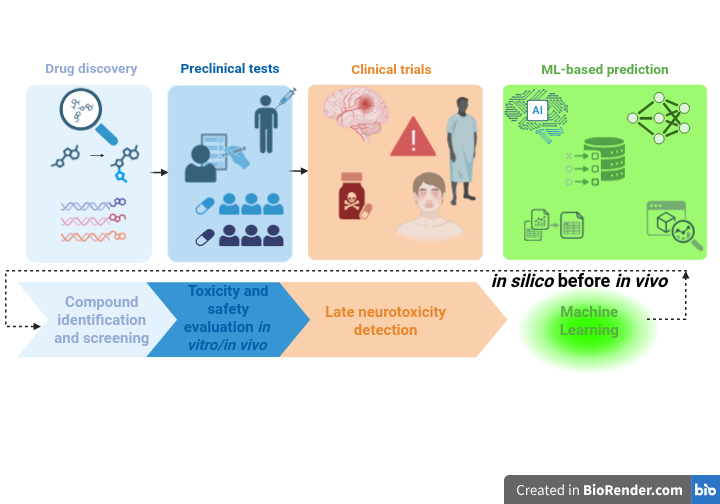

## Bibliographic research strategy

The scientific articles used in this project were selected through **systematic literature searches** conducted primarily on **PubMed**, and complemented with **ScienceDirect**, **Nature**, and **Frontiers** databases when relevant.  

The goal of this literature review was to identify recent and high-quality studies addressing:
- Machine learning approaches for toxicity prediction  
- Molecular fingerprint-based modeling of neurotoxicity  

---

### Search methodology

Search queries were formulated as **Boolean combinations** tailored to the main research axes of this project.  

- **Toxicological modeling** 

The following query was used: ("machine learning" AND "structural representations" AND "model validation" AND toxicity)

- **AI applied to toxicology**  

("AI-based toxicity prediction" AND "drug discovery")

- **Neurotoxicity prediction models**  

("neurotoxicity prediction" AND "machine learning")






In [24]:
# ############################## #
# Imports and environment setup  #
# ############################## #

# System and file handling
import os
import sys
import re
import gzip
import shutil
import json
import csv
from time import sleep
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch, Circle
from wordcloud import WordCloud  

# Web requests and APIs
import urllib.request   
import requests
import requests_cache
from concurrent.futures import ThreadPoolExecutor, as_completed

# Cheminformatics
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs, inchi, Descriptors, Crippen, QED, rdMolDescriptors
from chembl_webresource_client.new_client import new_client

# Machine Learning tools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Utilities
from tqdm import tqdm
from IPython.display import display, Markdown, HTML
import warnings
import platform
import textwrap



# Quick version check
print("Python:", sys.version.split()[0])
print("RDKit:", rdkit.__version__)
print("pandas:", pd.__version__, "| numpy:", np.__version__)


Python: 3.11.13
RDKit: 2024.03.5
pandas: 2.2.2 | numpy: 1.26.4


In [25]:
# ########################################### #
# General configuration and visual settings
# ########################################### #

# --- Colors ---
violet_main   = "#6A5ACD"   # primary violet for neurotoxic compounds
green_light   = "#4BBE54"   # green for non-neurotoxic or approved compounds
violet_dark   = "#4B0082"   # darker violet for emphasis or secondary plots
gray_light    = "#D3D3D3"   # neutral gray for backgrounds or outlines

# Extended palette used in regulatory / clinical plots
blue_approved       = "#6BAED6"   # blue — approved compounds (positive status)
red_not_approved    = "#DD545F"   # red — not approved (negative status)
teal_dark_toxic     = "#4C7F7A"   # dark teal — approved & neurotoxic
teal_light_non_tox  = "#78C7B4"   # light teal — approved & non-neurotoxic
violet_red_toxic    = "#A341B0"   # violet-red — not approved & neurotoxic
rose_light_non_tox  = "#E58E8E"   # rose-pink — not approved & non-neurotoxic

# --- Plot style ---
sns.set_theme(style="whitegrid", font_scale=1.1)

# --- Directories ---
data_dir = Path("data")
processed_dir = data_dir / "processed"
images_dir = Path("images")

processed_dir.mkdir(parents=True, exist_ok=True)
images_dir.mkdir(exist_ok=True)


## Reproducibility and environment setup

To ensure full reproducibility of this work, a conda environment was created using the file `environment.yml`.  
It contains all the required dependencies for cheminformatics, data analysis, and machine learning tasks.

This environment can be recreated using:
```bash
conda env create -f environment.yml
conda activate neurotox

name: neurotox
channels:
  - conda-forge
dependencies:
  - python=3.11
  - rdkit=2024.03.5
  - pandas=2.2.2
  - numpy=1.26.4
  - scikit-learn=1.5.2
  - xgboost=2.1.1
  - lightgbm=4.5.0
  - matplotlib=3.9.2
  - seaborn=0.13.2
  - shap=0.46.0
  - imbalanced-learn=0.12.3
  - tqdm=4.66.4
  - requests=2.32.3
  - jupyterlab=4.2.5
  - pip
  - pip:
      - chembl_webresource_client==0.10.9
      - pubchempy==1.0.4
      - wordcloud==1.9.3



In [26]:
with open("environment.yml", "w") as f:
    f.write("""
name: neurotox
channels:
  - conda-forge
dependencies:
  - python=3.11
  - rdkit=2024.03.5
  - pandas=2.2.2
  - numpy=1.26.4
  - scikit-learn=1.5.2
  - xgboost=2.1.1
  - lightgbm=4.5.0
  - matplotlib=3.9.2
  - seaborn=0.13.2
  - shap=0.46.0
  - imbalanced-learn=0.12.3
  - tqdm=4.66.4
  - requests=2.32.3
  - jupyterlab=4.2.5
  - pip
  - pip:
      - chembl_webresource_client==0.10.9
      - pubchempy==1.0.4
      - wordcloud==1.9.3
""")
print("environment.yml file successfully created.")

environment.yml file successfully created.


# ############################## #
# Data                          #
# ############################## #

## I) SIDER database

### Why SIDER?

To predict drug-induced neurotoxicity, we first need a reliable database of known **adverse drug reactions (ADR)**.  
The **SIDER (Side Effect Resource)** database is one of the most widely used open resources in pharmacovigilance.  

It compiles side effects reported in official drug package inserts and maps them to the standardized terminology **MedDRA** (*Medical Dictionary for Regulatory Activities*).

---

### SIDER content
- ≈ **1,430 drugs** covered  
- ≈ **5,868 distinct adverse effects**  
- ≈ **140,000 drug–ADR pairs**  
- Main tables used:
  - `drug_names.tsv` → drug identifiers and names  
  - `meddra_all_se.tsv` → mapping between ADRs and MedDRA codes  

---

### Neurotoxicity label definition

In this project, **SIDER** is used to construct a **binary neurotoxicity label** for each drug:

- `neurotoxic = 1` if the drug is associated with at least 1 or more ADR.

- `neurotoxic = 0` otherwise.

---

### Understanding MedDRA hierarchy

Each ADR term in MedDRA is organized hierarchically:

| Level | Meaning | Example |
|--------|----------|----------|
| **LLT (Lowest Level Term)** | Very specific term | *Grand mal seizure* |
| **PT (Preferred Term)** | Standardized group of LLTs | *Seizure* |
| **HLT / HLGT / SOC** | Broader aggregation levels | *Nervous system disorders* |

---

### Labeling Strategy

A single, **strict labeling strategy** was adopted to ensure reliable identification of neurotoxic drugs.  
Each drug was labeled as **neurotoxic (1)** if it was associated with at least one **Preferred Term (PT)** from a curated list of clearly neurotoxic adverse effects extracted from MedDRA, such as:

*Seizure, Convulsion, Peripheral neuropathy, Tremor, Memory impairment, Cognitive disorder, Neuralgia, Ataxia.*

Drugs without any of these neurotoxic PTs were labeled as **non-neurotoxic (0)**.

This approach prioritizes **label quality over quantity**, following best practices in toxicoinformatics to reduce noise from common, non-specific ADRs such as *Headache* or *Dizziness*.

---

### References

- [Kuhn et al., 2016 — *SIDER: a public resource of drug side effects*, Nucleic Acids Research](https://academic.oup.com/nar/article/44/D1/D1075/2502602?login=false)  
- [Seal, 2025 — *Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World*, ACS Chem. Res. Tox.](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033)  
- [Pang et al., 2025 — *NeuTox 2.0: Hybrid deep learning for neurotoxicity screening*, Environment International](https://www.sciencedirect.com/science/article/pii/S0160412024008316)


### SIDER data files

**Source:** [SIDER — Side Effect Resource](http://sideeffects.embl.de/download/)  

The raw files provided by **SIDER** do not include column headers; column names are only described in the official documentation (`README`).  

To improve readability and facilitate data manipulation, explicit column names were manually added based on the official schema.

---

### Files used

- **`drug_names.tsv`**  
  Contains the correspondence between **STITCH identifiers** and **drug names**.  

- **`meddra_all_se.tsv.gz`**  
  Lists associations between drugs and adverse drug reactions (ADRs) according to the standardized **MedDRA** vocabulary (*Medical Dictionary for Regulatory Activities*).

---

### Main columns

| Column | Description |
|:--|:--|
| `stitch_id_flat` / `stitch_id_stereo` | Flat and stereo identifiers of each drug (STITCH format). |
| `umls_id`, `umls_id_raw` | UMLS concept identifiers for side effects. |
| `meddra_type` | Indicates the MedDRA hierarchy level of the term (e.g., PT, LLT, etc.). |
| `side_effect_name` | Text name of the reported adverse effect. |

---

These tables form the **foundation of the neurotoxicity labeling process**,  which links drug identifiers to standardized MedDRA adverse effect terms.


In [4]:
# ############################## #
# Download and prepare SIDER data #
# ############################## #

# Make sure the data folder exists
os.makedirs("data", exist_ok=True)

# URLs for SIDER source files
url_drug_names = "http://sideeffects.embl.de/media/download/drug_names.tsv"
url_meddra_all_se = "http://sideeffects.embl.de/media/download/meddra_all_se.tsv.gz"

# Define local paths
path_drug_names = "data/drug_names.tsv"
path_meddra_all_se_gz = "data/meddra_all_se.tsv.gz"
path_meddra_all_se = "data/meddra_all_se.tsv"

# --- Helper functions ---

# Download a file from URL if it's not already present
def download_if_missing(url, path):
    if not os.path.exists(path):
        print(f"Downloading {url} → {path}")
        urllib.request.urlretrieve(url, path)
    else:
        print(f"File already exists: {path}")


# Decompress a .gz file into a regular file 
def decompress_gz(path_gz, path_out):
    if not os.path.exists(path_out):
        print(f"Decompressing {path_gz} → {path_out}")
        with gzip.open(path_gz, "rb") as f_in, open(path_out, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    else:
        print(f"Already decompressed: {path_out}")



# --- Download and decompress ---

download_if_missing(url_drug_names, path_drug_names)
download_if_missing(url_meddra_all_se, path_meddra_all_se_gz)
decompress_gz(path_meddra_all_se_gz, path_meddra_all_se)

# Remove the compressed file to keep the folder clean
if os.path.exists(path_meddra_all_se_gz):
    os.remove(path_meddra_all_se_gz)
    print(f"Removed: {path_meddra_all_se_gz}")


# --- Load and check the data ---

# The original files don't have headers
drug_names = pd.read_csv(path_drug_names, sep="\t", header=None)
meddra_all_se = pd.read_csv(path_meddra_all_se, sep="\t", header=None)

# Add column names for clarity
if drug_names.shape[1] == 3:
    drug_names.columns = ["stitch_id_flat", "stitch_id_stereo", "drug_name"]
elif drug_names.shape[1] == 2:
    drug_names.columns = ["stitch_id", "drug_name"]

meddra_all_se.columns = [
    "stitch_id_flat",
    "stitch_id_stereo",
    "umls_id_raw",
    "meddra_type",
    "umls_id",
    "side_effect_name"
]

# Save the cleaned versions (with headers)
drug_names.to_csv("data/drug_names.tsv", sep="\t", index=False)
meddra_all_se.to_csv("data/meddra_all_se.tsv", sep="\t", index=False)

# Quick look at the first rows
print("\ndrug_names.tsv:")
print(drug_names.head())

print("\nmeddra_all_se.tsv:")
print(meddra_all_se.head())



Decompressing data/meddra_all_se.tsv.gz → data/meddra_all_se.tsv
Removed: data/meddra_all_se.tsv.gz

drug_names.tsv:
      stitch_id                 drug_name
0  CID100000085                 carnitine
1  CID100000119        gamma-aminobutyric
2  CID100000137          5-aminolevulinic
3  CID100000143                leucovorin
4  CID100000146  5-methyltetrahydrofolate

meddra_all_se.tsv:
  stitch_id_flat stitch_id_stereo umls_id_raw meddra_type   umls_id  \
0   CID100000085     CID000010917    C0000729         LLT  C0000729   
1   CID100000085     CID000010917    C0000729          PT  C0000737   
2   CID100000085     CID000010917    C0000737         LLT  C0000737   
3   CID100000085     CID000010917    C0000737          PT  C0687713   
4   CID100000085     CID000010917    C0000737          PT  C0000737   

        side_effect_name  
0       Abdominal cramps  
1         Abdominal pain  
2         Abdominal pain  
3  Gastrointestinal pain  
4         Abdominal pain  



#################### drug_names ####################
Shape: 1430 rows × 2 columns

Data types:


dtype
stitch_id  object
drug_name  object


Missing values:


missing_values
stitch_id               0
drug_name               0

############################################################

#################### meddra_all_se ####################
Shape: 309849 rows × 6 columns

Data types:


dtype
stitch_id_flat    object
stitch_id_stereo  object
umls_id_raw       object
meddra_type       object
umls_id           object
side_effect_name  object


Missing values:


missing_values
stitch_id_flat                 0
stitch_id_stereo               0
umls_id_raw                    0
meddra_type                  901
umls_id                      901
side_effect_name               0

############################################################


/tmp/ipykernel_14939/3239151572.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


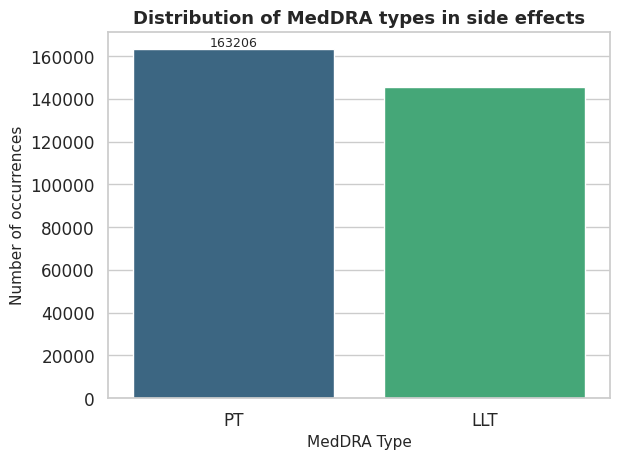

In [5]:
# ############################################### #
# Explore and summarize the SIDER data structure  #
# ############################################### #


# Get a clean overview of any dataframe
def summarize_df(df, name):
    print(f"\n{'#'*20} {name} {'#'*20}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    print("Data types:")
    display(df.dtypes.to_frame("dtype"))

    print("\nMissing values:")
    display(df.isna().sum().to_frame("missing_values"))
    print("#" * 60)


# Summarize both SIDER tables
summarize_df(drug_names, "drug_names")
summarize_df(meddra_all_se, "meddra_all_se")


# --- Visualize MedDRA type distribution ---

# Plot the frequency of each MedDRA type in the dataset
ax = sns.countplot(
    data=meddra_all_se,
    x="meddra_type",
    order=meddra_all_se["meddra_type"].value_counts().index,
    palette="viridis"
)

# Add count labels above the bars
ax.bar_label(ax.containers[0], fmt="%d", label_type="edge", fontsize=9)

plt.title("Distribution of MedDRA types in side effects", fontsize=13, weight="bold")
plt.xlabel("MedDRA Type", fontsize=11)
plt.ylabel("Number of occurrences", fontsize=11)
plt.tight_layout()
plt.show()


### MedDRA PT subset

The `meddra_all_se` file includes several MedDRA term levels:

- **LLT (Lower Level Term)** – the most specific form, often a synonym of a PT.  
- **PT (Preferred Term)** – the standardized reference term.  
- *(In extended databases, other levels such as HLT or SOC may also appear.)*

Here, we focused only on **Preferred Terms (PT)** by keeping rows where `meddra_type == "PT"`.  
This avoids synonym duplicates and ensures that we only keep standardized, interpretable side effects.  




### **MedDRA (PT) subset summary**
| Information | Value |
|--------------|--------|
| **Shape** | 163,206 rows × 6 columns |
| **Unique side effects (PT)** | 4,251 |
| **Saved file** | `data/meddra_all_se_PT.tsv` |

---

#### **Column overview and missing values**


dtype  missing_values
stitch_id_flat    object               0
stitch_id_stereo  object               0
umls_id_raw       object               0
meddra_type       object               0
umls_id           object               0
side_effect_name  object               0

---

/tmp/ipykernel_14939/368165975.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


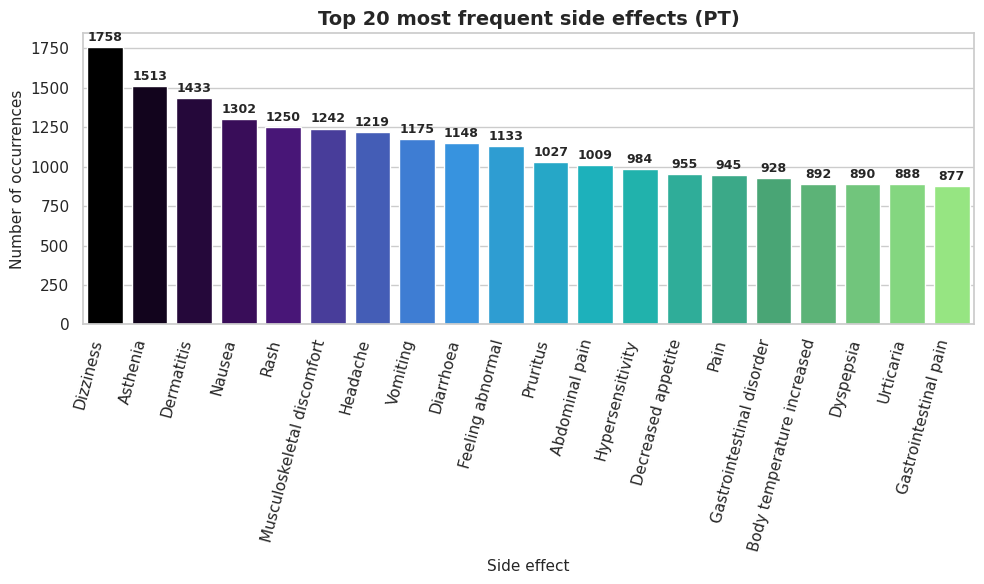

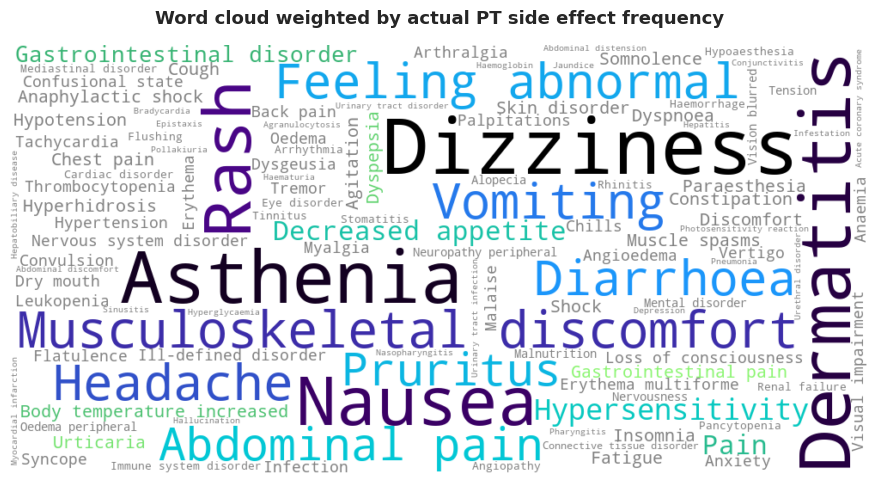

In [6]:
# ########################################## #
# Filter MedDRA data for Preferred Terms (PT) #
# ########################################## #


# Keep only "Preferred Terms" (PT) from the MedDRA dataset
meddra_pt = meddra_all_se[meddra_all_se["meddra_type"] == "PT"].copy()

# Save the filtered subset
pt_path = "data/meddra_all_se_PT.tsv"
meddra_pt.to_csv(pt_path, sep="\t", index=False)


# Display a structured summary of the MedDRA PT dataframe
def summarize_pt_data(df):
    n_total = len(df)
    n_cols = df.shape[1]
    n_unique = df["side_effect_name"].nunique()
    missing = df.isna().sum()

    display(Markdown(f"""
### **MedDRA (PT) subset summary**
| Information | Value |
|--------------|--------|
| **Shape** | {n_total:,} rows × {n_cols} columns |
| **Unique side effects (PT)** | {n_unique:,} |
| **Saved file** | `{pt_path}` |

---

#### **Column overview and missing values**
"""))
    display(pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing_values": missing,
    }))

    display(Markdown("---"))


# Run the summary on the filtered data
summarize_pt_data(meddra_pt)


# ############################################ #
# Top 20 most frequent side effects (PT level) #
# ############################################ #

# Compute frequency of each side effect name
top_effects = (
    meddra_pt["side_effect_name"]
    .value_counts()
    .head(20)
    .sort_values(ascending=False)
)

# Custom gradient colormap 
colors = ["#000000", "#4B0082", "#1E90FF", "#00CED1", "#3CB371", "#8CF572"]
cmap = LinearSegmentedColormap.from_list("neuro_gradient", colors, N=256)

# Map colors to effects
palette = [cmap(i / (len(top_effects) - 1)) for i in range(len(top_effects))]
color_map = dict(zip(top_effects.index, palette))

# Barplot 

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    x=top_effects.index,
    y=top_effects.values,
    palette=[color_map[effect] for effect in top_effects.index],
    legend=False
)

# Add counts above the bars
for i, v in enumerate(top_effects.values):
    ax.text(i, v + 20, str(v), ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.title("Top 20 most frequent side effects (PT)", fontsize=14, weight="bold")
plt.xlabel("Side effect", fontsize=11)
plt.ylabel("Number of occurrences", fontsize=11)
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()


# ######################################## #
# Word cloud of PT side effect frequencies #
# ######################################## #

# Build frequency dictionary for word cloud
freqs = meddra_pt["side_effect_name"].value_counts().to_dict()

# Assign the same color scale to each word
def exact_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in color_map:
        r, g, b, *_ = color_map[word]
        return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"
    else:
        return "grey"

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    collocations=False,
    prefer_horizontal=0.9,
    min_font_size=8,
    max_font_size=90
).generate_from_frequencies(freqs)

wordcloud.recolor(color_func=exact_color_func)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    "Word cloud weighted by actual PT side effect frequency",
    fontsize=13,
    weight="bold",
    pad=15
)
plt.tight_layout()
plt.show()



#### About the MedDRA structure

Although MedDRA is hierarchically organized up to the **SOC (System Organ Class)** level, the SIDER version used here only provides LLT/PT terms.  
To explore neurotoxicity, we therefore approximate the *“Nervous system disorders”* SOC by filtering PT terms that include strong neurological keywords (e.g., *seizure, neuropathy, tremor, ataxia*).  
This manual selection is a common and validated approach in recent pharmacovigilance studies.

---

#### References

- [Identification of potential drug-induced neuralgia signals through disproportionality analysis of the FAERS database (2024)](https://pubmed.ncbi.nlm.nih.gov/40808677/)  
- [Integrating molecular fingerprints with machine learning for neurotoxicity prediction (2025)](https://journals.lww.com/atn/fulltext/2025/09000/integrating_molecular_fingerprints_with_machine.2.aspx)  
- [Seal et al., *ACS Chemical Research in Toxicology*, 2025 — *Machine Learning for Toxicity Prediction Using Chemical Structures*](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033)

---

#### Next step

We’ll now identify **PTs explicitly linked to neurological effects**, based on manually curated keyword patterns such as:

| Category | Example PT keywords |
|-----------|--------------------|
| **Convulsions / Seizures** | seizure, convulsion, epilepsy, epileptic |
| **Peripheral neuropathies** | neuropathy, neuralgia, polyneuropathy, paresthesia, hypoesthesia |
| **Motor disorders** | tremor, ataxia, dystonia, parkinsonism, dyskinesia, rigidity |
| **Cognitive disorders** | memory impairment, amnesia, confusion, cognitive disorder, dementia-like |
| **Psychiatric-related (optional)** | hallucination, psychosis, agitation, depression, anxiety |
| **Other neurological symptoms** | dizziness, vertigo, syncope, headache *(less specific)* |


In [7]:
# ############################################# #
# Identify neurologically related PT terms (regex)
# ############################################# #

# --- Define regex patterns for neurological PTs  ---

keywords_neuro = {
    "seizure_convulsion":  r"\bseizur|\bconvuls|\bepilep|grand\s*mal|petit\s*mal",
    "neuropathy_neuralgia": r"\bneuro(?:pathy|pathies)\b|\bpolyneurop|\bperipheral\s+neuropathy|\bneuralg|\bpar(?:a|ae)sthes|\bhypo(?:a|e)sthes|\bhyper(?:a|e)sthes",
    "motor_disorders":     r"\btremor|\btremulous|\bataxi|\bdystoni|\bdyskines|\bparkinson|\brigidi|\bakinesia|\bbradykinesia",
    "cognitive":           r"memory\s+impairment|\bamnesia|\bamnestic|\bcognit|cognitive\s+disorder|\bconfus|\bdelirium|\bdementia",
    "coma_syncope":        r"\bcoma|\bsyncop|loss\s+of\s+consciousness",
    "myoclonus":           r"\bmyoclon",
    "encephalo_meningeal": r"\bencephalopath|\bencephaliti|\bmeningiti",
    "nystagmus":           r"\bnystagmus",
    "guillain_barre":      r"guillain[- ]?barr(?:e|é)",
}


# --- Regex compilation and pattern matching ---

# Compile regex patterns (case-insensitive)
def compile_patterns(patterns: dict[str, str]) -> dict[str, re.Pattern]:
    return {k: re.compile(v, flags=re.IGNORECASE) for k, v in patterns.items()}


# Return the list of categories that match a given PT term
def match_categories(term: str, compiled_patterns: dict[str, re.Pattern]) -> list[str]:
    return [cat for cat, rx in compiled_patterns.items() if rx.search(term)]


# Match all PTs and collect results by category
def collect_matches(pt_terms: pd.Series, compiled_patterns: dict[str, re.Pattern]) -> tuple[dict[str, list[str]], list[str]]:
    matches = {cat: [] for cat in compiled_patterns}
    for term in pt_terms:
        for cat, rx in compiled_patterns.items():
            if rx.search(term):
                matches[cat].append(term)

    # Clean duplicates and sort alphabetically
    matches = {cat: sorted(set(lst), key=str.casefold) for cat, lst in matches.items()}
    union = sorted({pt for lst in matches.values() for pt in lst}, key=str.casefold)
    return matches, union


# --- Extract unique PT terms ---

assert "side_effect_name" in meddra_pt.columns, "Column 'side_effect_name' is missing from meddra_pt."

pt_terms = (
    meddra_pt["side_effect_name"]
    .dropna()
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .unique()
    .tolist()
)


# --- Apply regex matching ---

compiled_patterns = compile_patterns(keywords_neuro)
category_matches, neuro_pt_list = collect_matches(pt_terms, compiled_patterns)


# --- Save results ---

output_dir = Path("data")
output_dir.mkdir(exist_ok=True)

list_path = output_dir / "PT_neuro.txt"
audit_path = output_dir / "PT_neuro_by_category.csv"

pd.Series(neuro_pt_list, name="side_effect_name").to_csv(list_path, index=False, header=False)

audit_rows = [(cat, pt) for cat, lst in category_matches.items() for pt in lst]
audit_df = pd.DataFrame(audit_rows, columns=["category", "side_effect_name"])
audit_df.to_csv(audit_path, index=False)


# --- Summary output ---

display(Markdown(f"""
### **Summary of neurological PT extraction**

| Information | Value |
|--------------|--------|
| **Total unique PTs** | {len(pt_terms):,} |
| **Neurological PTs identified** | {len(neuro_pt_list):,} |
| **Number of categories** | {len(category_matches):,} |
| **Generated files** | [`{list_path.name}`](./{list_path})  &  [`{audit_path.name}`](./{audit_path}) |

---
"""))



### **Summary of neurological PT extraction**

| Information | Value |
|--------------|--------|
| **Total unique PTs** | 4,251 |
| **Neurological PTs identified** | 103 |
| **Number of categories** | 9 |
| **Generated files** | [`PT_neuro.txt`](./data/PT_neuro.txt)  &  [`PT_neuro_by_category.csv`](./data/PT_neuro_by_category.csv) |

---


/tmp/ipykernel_14939/404037071.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


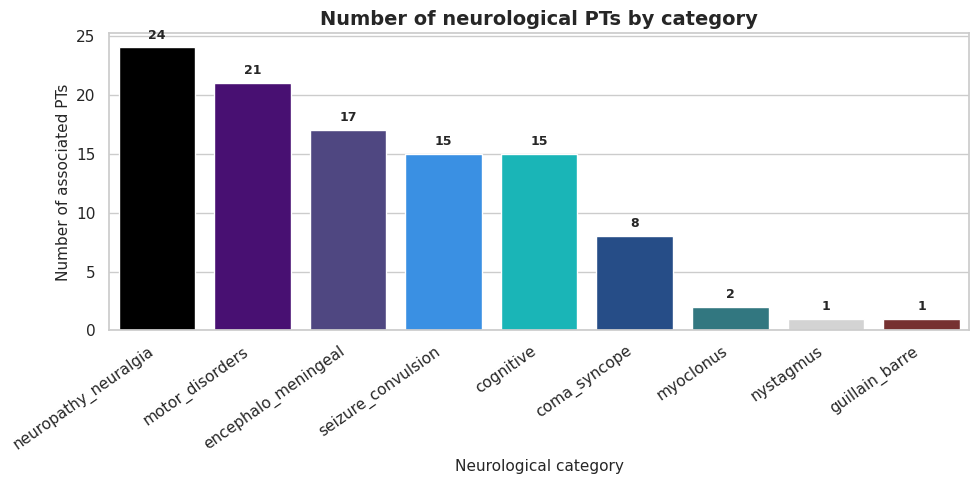

Barplot saved → images/neuro_pt_by_category_barplot.png


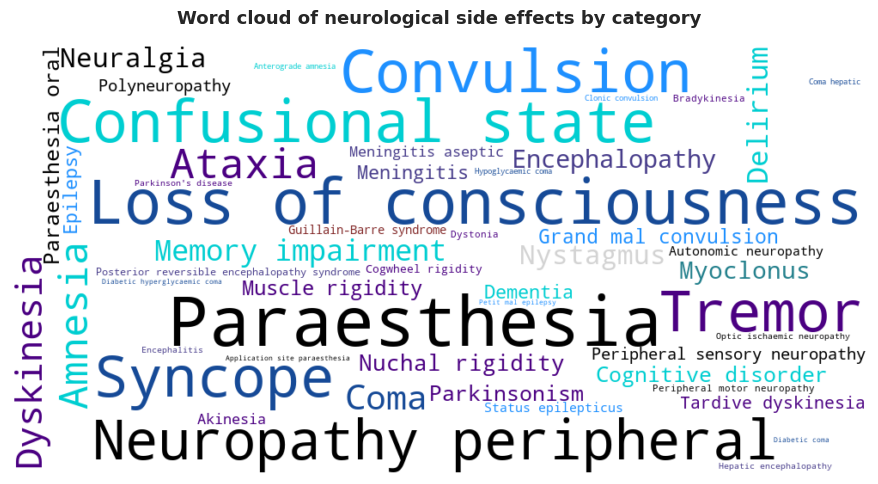

Wordcloud saved → images/neuro_pt_by_category_wordcloud.png


In [8]:
# ######################################################## #
# Visualize neurological PT categories 
# ######################################################## #

# --- Custom color palette

custom_colors = [
    "#000000",  
    "#4B0082",  
    "#483D8B",  
    "#1E90FF", 
    "#00CED1", 
    "#164A97",  
    "#25818D", 
    "#D3D3D3",  
    "#812626ED" 
]

# Automatically match one color per category
categories = audit_df["category"].value_counts().index.tolist()
palette = sns.color_palette(custom_colors, n_colors=len(categories))
color_map = dict(zip(categories, palette))


# ############################################# #
# Bar plot: number of neurological PTs per category
# ############################################# #

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

category_counts = audit_df["category"].value_counts()

ax = sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette=[color_map[c] for c in category_counts.index]
)

# Add count labels above bars
for i, (cat, val) in enumerate(category_counts.items()):
    ax.text(i, val + 0.5, str(val), ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.title("Number of neurological PTs by category", fontsize=14, weight="bold")
plt.xlabel("Neurological category", fontsize=11)
plt.ylabel("Number of associated PTs", fontsize=11)
plt.xticks(rotation=35, ha="right")
plt.tight_layout()

# Save figure
images_dir = Path("images")
images_dir.mkdir(exist_ok=True)
save_path = images_dir / "neuro_pt_by_category_barplot.png"

plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()
print(f"Barplot saved → {save_path}")


# ######################################### #
# Word cloud: neurological PTs colored by category
# ######################################### #

# Global PT frequencies in the full MedDRA dataset
pt_freqs_global = meddra_pt["side_effect_name"].value_counts().to_dict()

# Keep only neurological PTs (those matched earlier)
freqs = {pt: pt_freqs_global.get(pt, 1) for pt in audit_df["side_effect_name"]}

# Map each PT to its category
word_to_category = audit_df.set_index("side_effect_name")["category"].to_dict()

# Color function to color each word by its category
def category_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    cat = word_to_category.get(word)
    if cat and cat in color_map:
        r, g, b = [int(x * 255) for x in color_map[cat]]
        return f"rgb({r},{g},{b})"
    else:
        return "gray"

# Generate the word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    collocations=False,
    prefer_horizontal=0.9,
    min_font_size=8,
    max_font_size=80,
).generate_from_frequencies(freqs)

# Apply the color mapping by category
wordcloud.recolor(color_func=category_color_func)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of neurological side effects by category",
          fontsize=13, weight="bold", pad=15)
plt.tight_layout()

# Save figure
save_path = images_dir / "neuro_pt_by_category_wordcloud.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()

print(f"Wordcloud saved → {save_path}")


The bar plot and word cloud give an overview of how neurological side effects are distributed across different categories.

- **Neuropathy / neuralgia** and **motor disorders** are the most represented groups, covering a large number of distinct Preferred Terms (PTs).  
  This includes conditions like *peripheral neuropathy*, *paraesthesia*, *neuralgia*, *tremor*, *rigidity*, and *ataxia*, which are common indicators of neurotoxic effects.

- **Encephalo-meningeal** and **seizure / convulsion** terms are also frequent, reflecting more severe central nervous system involvement (e.g., *encephalopathy*, *meningitis*, *convulsion*, *epilepsy*).

- **Cognitive** and **coma / syncope** categories include high-level neurological dysfunctions such as *confusional state*, *memory impairment*, and *loss of consciousness*.

In the **word cloud**,  
- **Word size** represents the *actual frequency* of each PT across the complete MedDRA dataset.  
- **Word color** corresponds to the *neurological category* identified during pattern matching.  

This visualization highlights the clinical dominance of terms such as **Tremor**, **Convulsion**, and **Syncope**, which are among the most frequently reported neurological adverse effects in pharmacovigilance data.  



### Binary label per drug

**Goal:**  
Assign a binary label to each drug based on the presence of strong neurotoxic adverse effects.

**Definition:**  
A drug is labeled as `neurotoxic = 1` if it is associated with **at least one strong PT** from the curated list in `PT_neuro_.txt`.  
Otherwise, it is labeled as `neurotoxic = 0`.

**Procedure:**  
1. Filter the `meddra_all_se` DataFrame (from SIDER) to keep only the rows where `side_effect_name` appears in `PT_neuro_.txt`.  
2. For each `stitch_id_flat`, mark the drug as **neurotoxic (1)** if it has at least one matching PT.  
3. All other drugs are marked as **non-neurotoxic (0)**.


In [9]:
# ########################################### #
# Binary neurotoxicity label per drug
# ########################################### #

# --- Load and clean the list of neurological PTs ---

to_exclude = re.compile(r"\b(application|injection|infusion)\s+site\b", flags=re.IGNORECASE)
pt_path = Path("data/PT_neuro.txt")

pt_neuro = (
    pd.read_csv(pt_path, header=None, names=["pt"])
      .pt.astype(str)
      .str.strip()
)

# Remove "site reactions" and other unwanted PTs
pt_neuro_clean = pt_neuro[~pt_neuro.str.contains(to_exclude, regex=True, na=False)]
pt_neuro_clean = set(pt_neuro_clean)


# --- Harmonize drug identifiers ---

if "stitch_id_flat" not in drug_names.columns:
    if "stitch_id" in drug_names.columns:
        drug_names = drug_names.rename(columns={"stitch_id": "stitch_id_flat"})
    else:
        raise KeyError("drug_names must contain 'stitch_id_flat' or 'stitch_id'.")

all_drugs = (
    drug_names[["stitch_id_flat", "drug_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)


# --- Filter SIDER data for neurological PTs only ---

required_cols = {"stitch_id_flat", "side_effect_name"}
missing = required_cols.difference(meddra_pt.columns)
if missing:
    raise KeyError(f"Missing columns in meddra_pt: {missing}")

meddra_neuro = meddra_pt[meddra_pt["side_effect_name"].isin(pt_neuro_clean)].copy()


# --- Aggregate by drug and create binary label ---

agg = (
    meddra_neuro.groupby("stitch_id_flat")["side_effect_name"]
    .nunique()
    .reset_index(name="n_neuro_pt")
)

# Mark a drug as neurotoxic if it has at least one neurological PT
agg["neurotoxic"] = (agg["n_neuro_pt"] >= 1).astype(int)

# Include drugs with no neurological PTs
labels = (
    all_drugs.merge(agg, on="stitch_id_flat", how="left")
             .fillna({"n_neuro_pt": 0, "neurotoxic": 0})
)
labels["n_neuro_pt"] = labels["n_neuro_pt"].astype(int)
labels["neurotoxic"] = labels["neurotoxic"].astype(int)


# --- Save the labeled dataset ---

output_dir = Path("data/processed")
output_dir.mkdir(parents=True, exist_ok=True)
labels_path = output_dir / "labels_neuro.csv"

labels.to_csv(labels_path, index=False)


# --- Summary of generated labels ---

n_total = len(labels)
n_positive = int(labels["neurotoxic"].sum())
pct_positive = 100 * n_positive / n_total

display(Markdown(f"""
### **Summary of neurotoxicity label generation**

| Information | Value |
|--------------|--------|
| **Neurological PTs (raw)** | {pt_neuro.nunique():,} |
| **Neurological PTs (after cleaning)** | {len(pt_neuro_clean):,} |
| **Total molecules** | {n_total:,} |
| **Positive (≥1 neuro PT)** | {n_positive:,} |
| **Positive proportion** | {pct_positive:.2f}% |
| **Generated file** | [`{labels_path.name}`](./{labels_path}) |

---
"""))


# --- Label distribution ---

label_dist = (
    labels["neurotoxic"]
    .value_counts(dropna=False)
    .rename_axis("neurotoxic")
    .to_frame("count")
)

display(Markdown("#### **Label distribution (neurotoxic = 1):**"))
display(label_dist)


/tmp/ipykernel_14939/2709243416.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pt_neuro_clean = pt_neuro[~pt_neuro.str.contains(to_exclude, regex=True, na=False)]



### **Summary of neurotoxicity label generation**

| Information | Value |
|--------------|--------|
| **Neurological PTs (raw)** | 103 |
| **Neurological PTs (after cleaning)** | 100 |
| **Total molecules** | 1,430 |
| **Positive (≥1 neuro PT)** | 1,059 |
| **Positive proportion** | 74.06% |
| **Generated file** | [`labels_neuro.csv`](./data/processed/labels_neuro.csv) |

---


#### **Label distribution (neurotoxic = 1):**

count
neurotoxic       
1            1059
0             371

/tmp/ipykernel_14939/736051997.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


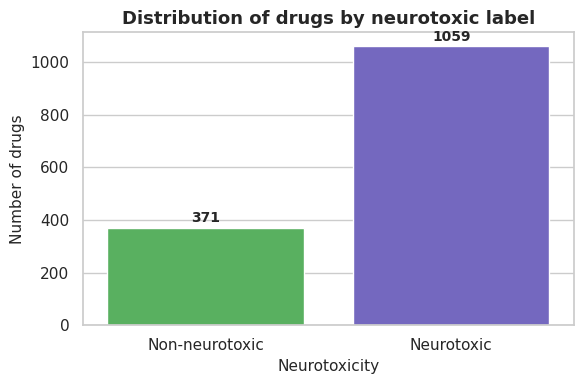

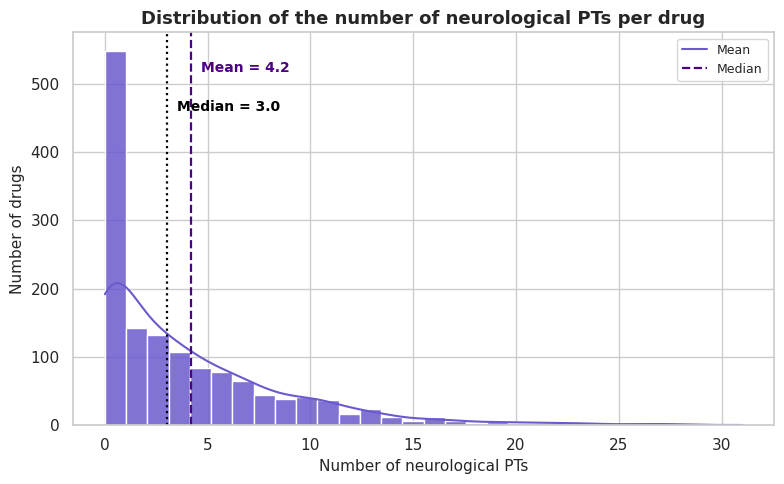

Histogram saved → images/distribution_neuro_pts_histogram.png


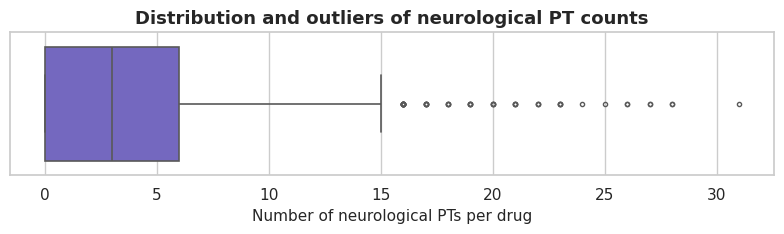

Boxplot saved → images/distribution_neuro_pts_boxplot.png


/tmp/ipykernel_14939/736051997.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


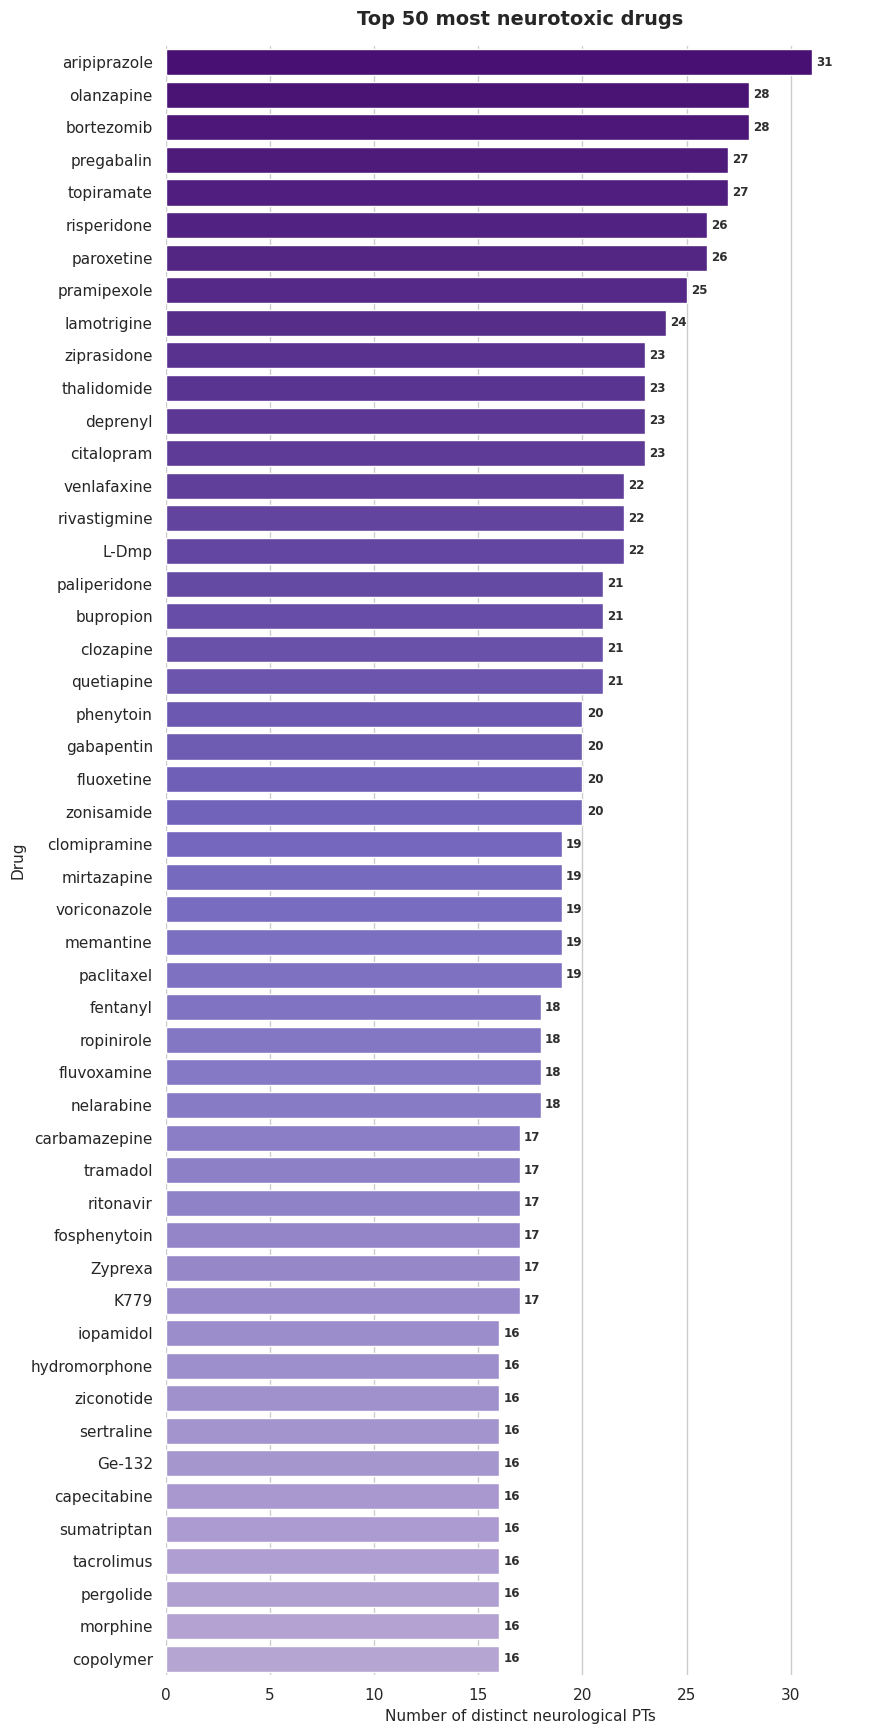

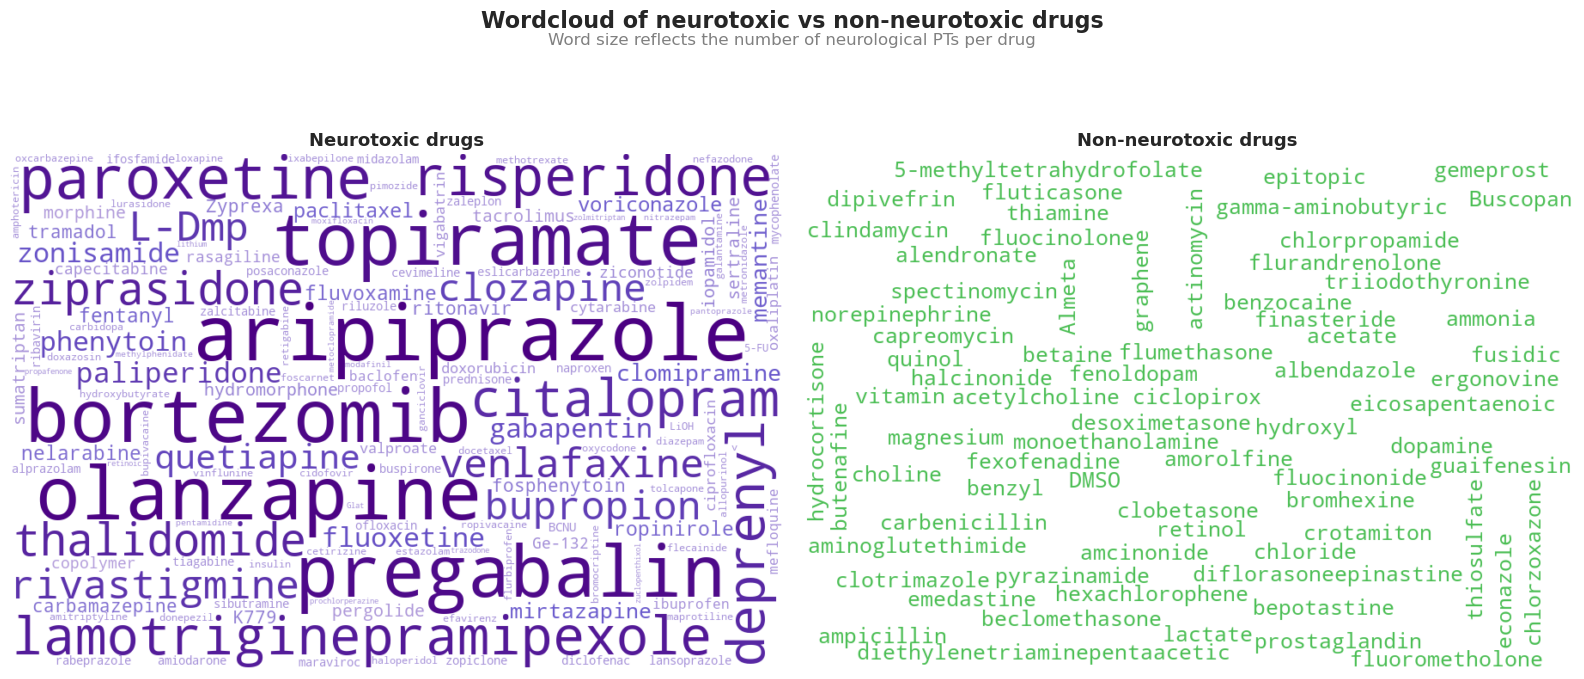

Wordclouds saved → images/wordcloud_neuro_vs_non_neuro.png


In [10]:
# #################################################### #
# Visual analysis of neurotoxicity label distribution
# #################################################### #

# --- Barplot: neurotoxic vs non-neurotoxic drugs ---
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="neurotoxic",
    data=labels,
    palette=[green_light, violet_main]
)

# Add exact counts above bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height() + 10),
        ha="center", va="bottom", fontsize=10, weight="bold"
    )

plt.title("Distribution of drugs by neurotoxic label", fontsize=13, weight="bold")
plt.xlabel("Neurotoxicity", fontsize=11)
plt.ylabel("Number of drugs", fontsize=11)
plt.xticks([0, 1], ["Non-neurotoxic", "Neurotoxic"])
plt.tight_layout()
plt.show()


# --- Histogram: number of neurological PTs per drug ---
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    labels["n_neuro_pt"], bins=30, kde=True,
    color=violet_main, edgecolor="white", alpha=0.85
)

# Mean and median lines
mean_val = labels["n_neuro_pt"].mean()
median_val = labels["n_neuro_pt"].median()

plt.axvline(mean_val, color=violet_dark, linestyle="--", lw=1.6)
plt.axvline(median_val, color="black", linestyle=":", lw=1.6)

plt.text(mean_val + 0.5, ax.get_ylim()[1]*0.9,
         f"Mean = {mean_val:.1f}", color=violet_dark,
         fontsize=10, weight="bold")
plt.text(median_val + 0.5, ax.get_ylim()[1]*0.8,
         f"Median = {median_val:.1f}", color="black",
         fontsize=10, weight="bold")

plt.title("Distribution of the number of neurological PTs per drug", fontsize=13, weight="bold")
plt.xlabel("Number of neurological PTs", fontsize=11)
plt.ylabel("Number of drugs", fontsize=11)
plt.legend(["Mean", "Median"], loc="upper right", frameon=True, fontsize=9)
plt.tight_layout()

save_path = images_dir / "distribution_neuro_pts_histogram.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Histogram saved → {save_path}")


# --- Boxplot: dispersion of neurological PT counts ---
plt.figure(figsize=(8, 2.5))
sns.boxplot(
    x="n_neuro_pt", data=labels,
    color=violet_main, fliersize=3, linewidth=1.2
)

plt.title("Distribution and outliers of neurological PT counts", fontsize=13, weight="bold")
plt.xlabel("Number of neurological PTs per drug", fontsize=11)
plt.tight_layout()

save_path = images_dir / "distribution_neuro_pts_boxplot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Boxplot saved → {save_path}")


# #################################################### #
# Top neurotoxic drugs (by number of neurological PTs)
# #################################################### #

from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud

# Select the 50 most neurotoxic drugs
top_drugs = (
    labels.query("neurotoxic == 1")
          .sort_values("n_neuro_pt", ascending=False)
          .head(50)
          .reset_index(drop=True)
)

# Violet gradient colormap 
violet_cmap = LinearSegmentedColormap.from_list(
    "violet_grad", [violet_dark, violet_main, "#B39DDB"], N=256
)

palette = [violet_cmap(i / (len(top_drugs)-1)) for i in range(len(top_drugs))]
drug2color = dict(zip(top_drugs["drug_name"], palette))

height = max(6, len(top_drugs) * 0.35)

plt.figure(figsize=(9, height))
ax = sns.barplot(
    y="drug_name", x="n_neuro_pt",
    data=top_drugs,
    palette=[drug2color[n] for n in top_drugs["drug_name"]]
)

for i, (v, name) in enumerate(zip(top_drugs["n_neuro_pt"], top_drugs["drug_name"])):
    ax.text(v + 0.2, i, str(v), va="center", fontsize=8.5, weight="bold", color="#2E2E2E")

plt.title("Top 50 most neurotoxic drugs", fontsize=14, weight="bold", pad=15)
plt.xlabel("Number of distinct neurological PTs", fontsize=11)
plt.ylabel("Drug", fontsize=11)
plt.xlim(0, top_drugs["n_neuro_pt"].max() + 3)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


# #################################################### #
# Wordclouds: neurotoxic vs non-neurotoxic drugs
# #################################################### #

# Frequencies for word size (based on n_neuro_pt)
freq_neuro = labels.query("neurotoxic == 1").set_index("drug_name")["n_neuro_pt"].to_dict()

def neuro_color_func(word, *args, **kwargs):
    if word in drug2color:
        r, g, b, a = drug2color[word]
    else:
        r, g, b, a = violet_cmap(0.9)
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

wc_neuro = WordCloud(
    width=900, height=600, background_color="white",
    collocations=False, prefer_horizontal=0.9,
    min_font_size=8, max_font_size=90
).generate_from_frequencies(freq_neuro)
wc_neuro.recolor(color_func=neuro_color_func)

# Non-neurotoxic drugs (uniform green)
freq_non_neuro = labels.query("neurotoxic == 0").assign(weight=1).set_index("drug_name")["weight"].to_dict()

def uniform_green(word, *args, **kwargs):
    return "rgb(75, 190, 84)" 

wc_non_neuro = WordCloud(
    width=900, height=600, background_color="white",
    color_func=uniform_green, collocations=False,
    prefer_horizontal=0.9, min_font_size=25, max_font_size=25
).generate_from_frequencies(freq_non_neuro)

# --- Display side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(wc_neuro, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Neurotoxic drugs", fontsize=13, weight="bold")

axes[1].imshow(wc_non_neuro, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Non-neurotoxic drugs", fontsize=13, weight="bold")

fig.suptitle("Wordcloud of neurotoxic vs non-neurotoxic drugs", fontsize=16, weight="bold", y=1.02)
fig.text(0.5, 0.97, "Word size reflects the number of neurological PTs per drug", ha="center", fontsize=12, color="gray")

plt.tight_layout(rect=[0, 0, 1, 0.95])

save_path = images_dir / "wordcloud_neuro_vs_non_neuro.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Wordclouds saved → {save_path}")


### Interpretation of neurotoxicity label distribution 

#### 1. Overall label distribution

Out of **1,430 drugs**, **1,059 are labeled as neurotoxic (≈74%)**.  

For machine learning, this results in a **moderate-to-strong class imbalance**:

| Class | Count | Percentage |
|:--|--:|--:|
| Neurotoxic | 1,059 | 74% |
| Non-neurotoxic | 371 | 26% |

Although not extreme, this imbalance may bias a naive classifier toward predicting “neurotoxic” most of the time.  
→ **Mitigation strategies**: class weighting, SMOTE, or undersampling.

---

#### 2. Number of neurological PTs per drug

The number of neurological adverse effects per drug is **right-skewed**:  
most drugs have few neurological PTs, while a small subset has many.

- **Mean:** ≈ 4.2 PTs  
- **Median:** ≈ 3.0 PTs  

This “long-tail” pattern is typical in pharmacovigilance: a majority of drugs show 0–5 neurological side effects,  while a few compounds accumulate several dozen.

Such behavior is expected : CNS-acting drugs (antidepressants, antipsychotics, antiepileptics) naturally exhibit more recorded neurological effects.

---

#### 3. Outliers and highly neuroactive compounds

The boxplot identifies **outliers above ~15 neurological PTs**.  
These represent **biologically valid extremes**, not errors:

- **Antipsychotics:** olanzapine, risperidone, aripiprazole, quetiapine  
- **Antiepileptics:** lamotrigine, topiramate, pregabalin  
- **Chemotherapy agents:** bortezomib, paclitaxel  
- **Antidepressants:** paroxetine, venlafaxine, fluoxetine  

These drugs are **clinically relevant outliers** and should **not be removed** —  
they carry strong neurotoxic signals that the model needs to learn from.

---

#### 4. Visual comparison: neurotoxic vs non-neurotoxic drugs

The wordcloud confirms that:

- The **purple cloud (neurotoxic)** is dominated by psychotropics, anticonvulsants, and antidepressants — consistent with literature.  
- The **green cloud (non-neurotoxic)** mostly shows metabolic or peripheral compounds  
  (e.g., acetate, dopamine, choline) with limited CNS effects.

---

#### 5. Implications for machine learning

| Aspect | Impact on modeling |
|:--|:--|
| **Class imbalance** | Requires weighting or resampling (e.g., `class_weight`, SMOTE). |
| **Highly neuroactive outliers** | Should be kept, as they encode strong biological signals. |
| **Right-skewed distributions** | May benefit from scaling or transformation of continuous variables. |
| **Well-defined binary label** | Provides a robust target for supervised classification. |
| **Neuro PT counts as potential features** | Can be engineered as features (e.g., total PTs, neurotoxic ratio, therapeutic class). |


## II) Molecular feature preparation (PubChem & RDKit)

### Why molecular features?

To train a machine learning model, each drug must be represented numerically.  
This requires transforming its **chemical structure** into features that a model can interpret.

In this project, molecular information is obtained from **PubChem** (chemical structures) and from **ChEMBL** (biological targets).  
The goal is to convert each molecule’s structure into numerical vectors that capture chemical properties associated with neurotoxicity.

---

### Types of molecular representations

| Data type | Source | Description |
|:--|:--|:--|
| **SMILES** | PubChem | Linear representation of the molecule’s structure. Example: `"CC(=O)NC1=CC=C(O)C=C1"` for *Paracetamol*. |
| **Molecular fingerprints** | RDKit | Binary vectors (0/1) describing the presence of chemical substructures. |
| **Drug–target associations** | ChEMBL | Proteins or receptors that the drug binds to, useful for linking neurotoxicity to specific neurological targets (dopamine, GABA, Na⁺ channels, etc.). |

---

### Molecular fingerprints

Fingerprints are fixed-length binary vectors that encode chemical patterns.  
They are a standard input representation for QSAR and toxicity prediction models.

Two main types are used in this project:

| Fingerprint type | Size (bits) | Description |
|:--|--:|:--|
| **Morgan / ECFP4** | 1024 | Circular fingerprints capturing local atom environments within a defined radius (commonly used for toxicity prediction). |
| **MACCS Keys** | 166 | A predefined set of simple structural keys; less detailed but computationally efficient. |

These fingerprints are computed directly using **RDKit** from each molecule’s **SMILES** string.

---

### SMILES extraction from PubChem

The workflow for integrating PubChem data is as follows:

1. Convert **STITCH identifiers** from SIDER (e.g., `CID100004585`) into standard **PubChem CIDs** (e.g., `4585`).  
2. Retrieve **SMILES** strings from PubChem for each drug.  
3. Use **RDKit** to compute:
   - **Morgan/ECFP4** fingerprints (1024 bits)  
   - **MACCS** fingerprints (166 bits)  
4. Store all computed descriptors in a structured format (e.g., `.parquet` or `.csv`) for downstream ML modeling.

---

### References

- [Seal, 2025 — *Machine Learning for Toxicity Prediction Using Chemical Structures: Pillars for Success in the Real World*, ACS Chem. Res. Tox.](https://pubs.acs.org/doi/10.1021/acs.chemrestox.5c00033) — highlights the importance of standardized molecular fingerprints for toxicity modeling.  
- [Pang et al., 2025 — *NeuTox 2.0: Hybrid deep learning for neurotoxicity screening*, Environment International](https://www.sciencedirect.com/science/article/pii/S0160412024008316) — combines molecular and biological target information for improved neurotoxicity prediction.  
- [**PubChem Database** — National Center for Biotechnology Information (NCBI)](https://pubchem.ncbi.nlm.nih.gov/) — source of chemical structures and SMILES data.  
- [**ChEMBL Database** — European Bioinformatics Institute (EMBL-EBI)](https://www.ebi.ac.uk/chembl/) — resource for bioactivity data and drug–target associations.




---




In [11]:
# ########################################################  #
# Conversion STITCH → PubChem CID                              #
# ########################################################  #

# --- Load neurotoxicity-labeled dataset ---
labels_path = processed_dir / "labels_neuro.csv"
labels = pd.read_csv(labels_path)

# --- Output path ---
out_path = processed_dir / "labels_with_pubchem_cid.csv"

# --- Extract PubChem CID from STITCH identifiers ---
def extract_pubchem_cid(stitch_id):
    if pd.isna(stitch_id):
        return None
    match = re.search(r"CID(\d+)", str(stitch_id))
    if not match:
        return None
    cid = int(match.group(1))
    if cid > 100_000_000:
        cid -= 100_000_000
    return cid


# --- Apply conversion ---
labels["pubchem_cid"] = labels["stitch_id_flat"].apply(extract_pubchem_cid)

# --- Compute summary stats ---
n_total = len(labels)
n_valid = labels["pubchem_cid"].notna().sum()
pct_valid = 100 * n_valid / n_total
n_missing = labels["pubchem_cid"].isna().sum()
n_dups = labels["pubchem_cid"].duplicated().sum()

# --- Display summary ---
display(Markdown(f"""
### **Summary: STITCH → PubChem CID conversion**

| Information | Value |
|--------------|--------|
| **Total drugs** | {n_total:,} |
| **Valid PubChem CIDs** | {n_valid:,} / {n_total:,} ({pct_valid:.1f}%) |
| **Missing CIDs** | {n_missing:,} |
| **Duplicated CIDs** | {n_dups:,} |
| **Output file** | `{out_path.name}` |

{"Conversion successful: ready for SMILES extraction from PubChem."
 if pct_valid == 100 else "Partial conversion — some CIDs are missing."}
"""))

# --- Save converted file ---
labels.to_csv(out_path, index=False)
print(f"Saved with PubChem CIDs → {out_path}")



### **Summary: STITCH → PubChem CID conversion**

| Information | Value |
|--------------|--------|
| **Total drugs** | 1,430 |
| **Valid PubChem CIDs** | 1,430 / 1,430 (100.0%) |
| **Missing CIDs** | 0 |
| **Duplicated CIDs** | 0 |
| **Output file** | `labels_with_pubchem_cid.csv` |

Conversion successful: ready for SMILES extraction from PubChem.


Saved with PubChem CIDs → data/processed/labels_with_pubchem_cid.csv


Starting PubChem download for 1,430 compounds...

Dowloading PubChem (1,430 compounds)...


PubChem download: 100%|██████████| 1430/1430 [00:09<00:00, 153.85molécule/s]


Retrieved 1,430 compound records from PubChem.

Generating InChIKeys using RDKit...


InChIKey (RDKit): 100%|██████████| 1430/1430 [00:00<00:00, 2165.31compound/s]



### **Summary of PubChem SMILES / InChIKey extraction**

| Information | Value |
|--------------|--------|
| **Total drugs** | 1,430 |
| **Valid SMILES** | 1,430 (100.0%) |
| **Valid InChIKeys** | 1,430 (100.0%) |
| **Output file** | `labels_with_smiles_inchikey.csv` |



Saved final file with SMILES & InChIKeys → data/processed/labels_with_smiles_inchikey.csv


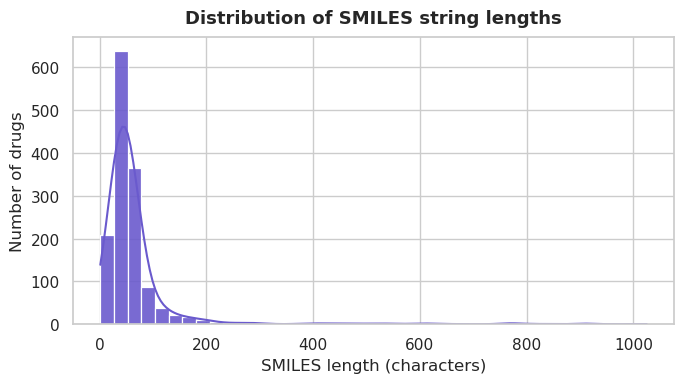

/tmp/ipykernel_14939/2649313875.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Mean length: 65.0
Median length: 47.0


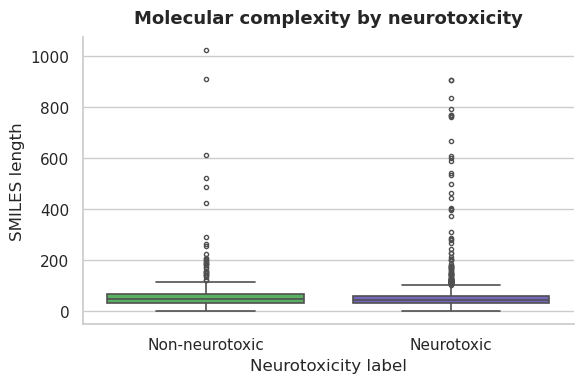

In [12]:
# ############################################################ #
# Retrieve SMILES and InChIKeys from PubChem + RDKit processing #
# ############################################################ #

# --- Disable RDKit warnings ---
RDLogger.DisableLog("rdApp.*")

# --- Load labeled dataset ---
labels_path = processed_dir / "labels_with_pubchem_cid.csv"
out_path = processed_dir / "labels_with_smiles_inchikey.csv"
labels = pd.read_csv(labels_path)

# --- Cleanup ---
if {"stitch_id_flat", "drug_name"}.issubset(labels.columns):
    mask_bad = (
        labels["stitch_id_flat"].astype(str).str.strip().eq("stitch_id") |
        labels["drug_name"].astype(str).str.strip().eq("drug_name")
    )
    if mask_bad.any():
        labels = labels.loc[~mask_bad].copy()

assert "pubchem_cid" in labels.columns, "Missing 'pubchem_cid' column in labels_with_pubchem_cid.csv"
labels["pubchem_cid"] = pd.to_numeric(labels["pubchem_cid"], errors="coerce").astype("Int64")

cids = labels["pubchem_cid"].dropna().astype(int).unique().tolist()
print(f"Starting PubChem download for {len(cids):,} compounds...")

# ============================================================ #
# Download SMILES and InChI from PubChem API                   #
# ============================================================ #

def chunker(seq, size=200):
    for i in range(0, len(seq), size):
        yield seq[i:i+size]

def fetch_props_batch(cids_batch):
    """Fetch SMILES and InChI info for a batch of PubChem CIDs."""
    props = "CanonicalSMILES,IsomericSMILES,ConnectivitySMILES,InChIKey"
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids_batch))}/property/{props}/JSON"
    try:
        r = requests.get(url, timeout=30)
        if r.status_code != 200:
            return pd.DataFrame(columns=["CID"])
        data = r.json()
        rows = data.get("PropertyTable", {}).get("Properties", [])
        return pd.DataFrame(rows)
    except Exception:
        return pd.DataFrame(columns=["CID"])


# --- Batch download ---
all_props = []
batches = list(chunker(cids, 200))

print(f"\nDowloading PubChem ({len(cids):,} compounds)...")

with tqdm(total=len(cids), desc="PubChem download", unit="molécule") as pbar:
    for batch in batches:
        df_batch = fetch_props_batch(batch)
        if not df_batch.empty:
            all_props.append(df_batch)
        sleep(0.25)
        pbar.update(len(batch))



props_df = pd.concat(all_props, ignore_index=True) if all_props else pd.DataFrame(columns=["CID"])
props_df.rename(columns={"CID": "pubchem_cid"}, inplace=True)
print(f"Retrieved {len(props_df):,} compound records from PubChem.")

# ============================================================ #
# Extract and clean SMILES                                     #
# ============================================================ #

props_df["smiles"] = pd.NA
for col in ("CanonicalSMILES", "IsomericSMILES", "ConnectivitySMILES"):
    if col in props_df.columns:
        props_df.loc[props_df["smiles"].isna(), "smiles"] = props_df[col]

props_df = props_df[["pubchem_cid", "smiles"]].drop_duplicates("pubchem_cid")
props_df["pubchem_cid"] = pd.to_numeric(props_df["pubchem_cid"], errors="coerce").astype("Int64")

# ============================================================ #
# Merge with neurotoxicity labels                              #
# ============================================================ #

merged = labels.merge(props_df, on="pubchem_cid", how="left")

# ============================================================ #
# Compute RDKit InChIKeys                                       #
# ============================================================ #

def rdkit_inchikey_from_smiles(smi):
    """Compute InChIKey from SMILES using RDKit."""
    if pd.isna(smi) or not str(smi).strip():
        return pd.NA
    try:
        mol = Chem.MolFromSmiles(str(smi))
        if mol is None:
            return pd.NA
        return inchi.MolToInchiKey(mol)
    except Exception:
        return pd.NA

print("\nGenerating InChIKeys using RDKit...")
merged["inchikey"] = [
    rdkit_inchikey_from_smiles(smi)
    for smi in tqdm(merged["smiles"].tolist(), desc="InChIKey (RDKit)", unit="compound")
]

# ============================================================ #
# Save final dataset + summary                                 #
# ============================================================ #

cols_order = ["stitch_id_flat", "drug_name", "n_neuro_pt", "neurotoxic", "pubchem_cid", "smiles", "inchikey"]
merged = merged[[c for c in cols_order if c in merged.columns] + [c for c in merged.columns if c not in cols_order]]

merged.to_csv(out_path, index=False)

n_total = len(merged)
n_smiles = int(merged["smiles"].notna().sum())
n_inchi = int(merged["inchikey"].notna().sum())

display(Markdown(f"""
### **Summary of PubChem SMILES / InChIKey extraction**

| Information | Value |
|--------------|--------|
| **Total drugs** | {n_total:,} |
| **Valid SMILES** | {n_smiles:,} ({100*n_smiles/n_total:.1f}%) |
| **Valid InChIKeys** | {n_inchi:,} ({100*n_inchi/n_total:.1f}%) |
| **Output file** | `{out_path.name}` |
"""))

print(f"\nSaved final file with SMILES & InChIKeys → {out_path}")

# ============================================================ #
# Visualizations                                                #
# ============================================================ #

merged["smiles_len"] = merged["smiles"].astype(str).str.len()

# --- Histogram of SMILES lengths ---
plt.figure(figsize=(7,4))
sns.histplot(merged["smiles_len"], bins=40, kde=True, color=violet_main, edgecolor="white", alpha=0.9)
plt.title("Distribution of SMILES string lengths", fontsize=13, weight="bold", pad=10)
plt.xlabel("SMILES length (characters)")
plt.ylabel("Number of drugs")
plt.tight_layout()
plt.show()

print(f"Mean length: {merged['smiles_len'].mean():.1f}")
print(f"Median length: {merged['smiles_len'].median():.1f}")

# --- Boxplot: SMILES length vs neurotoxicity ---
plt.figure(figsize=(6,4))
sns.boxplot(
    data=merged,
    x="neurotoxic",
    y="smiles_len",
    palette=[green_light, violet_main],
    fliersize=3, linewidth=1.2
)
plt.title("Molecular complexity by neurotoxicity", fontsize=13, weight="bold", pad=10)
plt.xlabel("Neurotoxicity label")
plt.ylabel("SMILES length")
plt.xticks([0,1], ["Non-neurotoxic", "Neurotoxic"])
sns.despine()
plt.tight_layout()
plt.show()



#### Distribution of SMILES string lengths

The distribution is **highly right-skewed**, meaning most drugs have relatively short SMILES strings while a few have very long ones.

- **Median ≈ 47 characters** → most compounds are small to medium-sized molecules.  
- **Outliers > 500–1000 characters** correspond to **complex or peptide-like structures**, such as chemotherapeutic agents or natural product derivatives.

**Chemical interpretation:**

Long SMILES strings often indicate **repetitive or extended molecular scaffolds** (multiple rings, long side chains), typical of drugs that can act on several biological targets (polypharmacology).  
Such compounds may have an increased likelihood of **neurotoxic side effects** due to their broader receptor interaction profiles.

---

#### Molecular complexity by neurotoxicity label

The boxplot compares molecular size (approximated by SMILES length) between neurotoxic and non-neurotoxic drugs.

- The **distributions are largely similar** between both classes.  
- There is a **slightly higher median SMILES length** among neurotoxic drugs.

Molecular size alone is **not a discriminative feature** for neurotoxicity.  
What differentiates neurotoxic compounds is not their overall size, but their **specific substructures**, such as aromatic rings, halogenated groups, or amine functionalities — and their **biological targets** (dopaminergic, GABAergic, sodium channels, etc.).

This confirms the need for **molecular fingerprints (ECFP, MACCS)**, which capture **structural motifs and functional groups**, rather than just molecular length or complexity.


Total molecules to process: 1,430



### **Summary of molecular fingerprint generation (ECFP4)**
| Information | Value |
|--------------|--------|
| **Total molecules processed** | 1,430 |
| **Valid fingerprints** | 1,430 (100.0%) |
| **Invalid fingerprints (unparsed SMILES)** | 0 |
| **Saved files** | `X_ECFP4_2048.npy`  /  `meta_labels.csv` |

Extraction successful — ECFP4 molecular fingerprints (2048 bits) are ready for machine learning.


#### **Preview of `meta_labels.csv`:**

stitch_id_flat                 drug_name  neurotoxic
0   CID100000085                 carnitine           1
1   CID100000119        gamma-aminobutyric           0
2   CID100000137          5-aminolevulinic           1
3   CID100000143                leucovorin           1
4   CID100000146  5-methyltetrahydrofolate           0

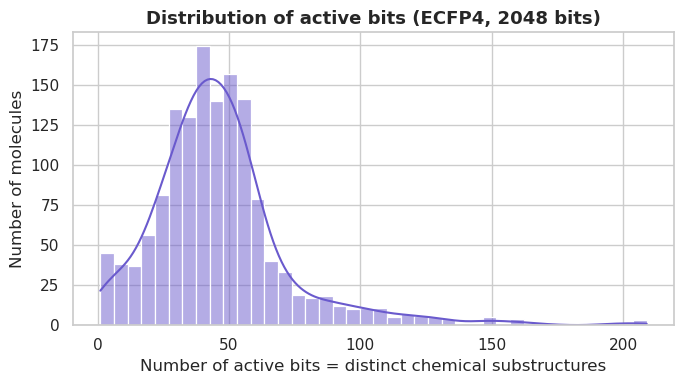

Mean active bits: 46.5  |  Median: 43.0


In [13]:
# ############################################################ #
# Generate molecular fingerprints (ECFP4, 2048 bits) with RDKit #
# ############################################################ #

# --- Disable RDKit warnings ---
RDLogger.DisableLog("rdApp.*")

# ============================================================ #
# Load and prepare input data                                  #
# ============================================================ #

fp_dir = processed_dir
df_smiles_path = fp_dir / "labels_with_smiles_inchikey.csv"
labels_path    = fp_dir / "labels_neuro.csv"

# Optimized reading
df_smiles = pd.read_csv(df_smiles_path, usecols=lambda c: c in {"stitch_id_flat", "drug_name", "smiles"})
labels    = pd.read_csv(labels_path,    usecols=["stitch_id_flat", "neurotoxic"])

# Merge and clean
df = (
    df_smiles.dropna(subset=["smiles"])
    .merge(labels, on="stitch_id_flat", how="left")
)

if "neurotoxic" not in df.columns:
    raise KeyError("Column 'neurotoxic' missing after merge — check labels_neuro.csv.")

df["neurotoxic"] = pd.to_numeric(df["neurotoxic"], errors="coerce").fillna(0).astype(int)
print(f"Total molecules to process: {len(df):,}")

# ============================================================ #
# SMILES → ECFP4 fingerprint conversion (2048 bits)            #
# ============================================================ #

# Conversion SMILES -> ECFP4 (Morgan fingerprint with radius=2, 2048 bits)
# Extended Connectivity Fingerprint (ECFP), also known as Morgan fingerprint.
# “4” corresponds to a chemical radius of 2 (2 bonds × 2 = 4).
# RDKit processes each atom, examines its neighborhood within 2 bonds,
# and converts each local pattern into a numerical identifier (“hash”).
# These identifiers are projected into a fixed-length binary vector (2048 bits).
# If a chemical substructure is present → the corresponding bit = 1, otherwise 0.
# Each molecule is therefore represented as a unique 2048-bit binary vector.

def smiles_to_ecfp(smi: str, radius: int = 2, n_bits: int = 2048):
    mol = Chem.MolFromSmiles(str(smi))
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


X_rows, keep_rows = [], []
bad = 0

for _, r in df.iterrows():
    arr = smiles_to_ecfp(r["smiles"])
    if arr is None:
        bad += 1
        continue
    X_rows.append(arr)
    keep_rows.append((r["stitch_id_flat"], r.get("drug_name", None), r["neurotoxic"]))

if not X_rows:
    raise RuntimeError("No valid fingerprints generated. Check the SMILES input file.")

X = np.vstack(X_rows)
meta = pd.DataFrame(keep_rows, columns=["stitch_id_flat", "drug_name", "neurotoxic"])

# ============================================================ #
# Save fingerprints and metadata                               #
# ============================================================ #

np.save(fp_dir / "X_ECFP4_2048.npy", X)
meta.to_csv(fp_dir / "meta_labels.csv", index=False)

n_total = len(df)
n_valid = len(meta)
pct_valid = 100 * n_valid / n_total
n_neuro = meta["neurotoxic"].sum()
pct_neuro = 100 * n_neuro / n_total

display(Markdown(f"""
### **Summary of molecular fingerprint generation (ECFP4)**
| Information | Value |
|--------------|--------|
| **Total molecules processed** | {n_total:,} |
| **Valid fingerprints** | {n_valid:,} ({pct_valid:.1f}%) |
| **Invalid fingerprints (unparsed SMILES)** | {bad:,} |
| **Saved files** | `X_ECFP4_2048.npy`  /  `meta_labels.csv` |

Extraction successful — ECFP4 molecular fingerprints (2048 bits) are ready for machine learning.
"""))

# meta_labels.csv --> links each fingerprint (X_ECFP4_2048.npy) to its metadata
# X_ECFP4_2048.npy --> NumPy array of shape (n_molecules, 2048)
# This X matrix will serve as the ML input representation.

display(Markdown("#### **Preview of `meta_labels.csv`:**"))
display(meta.head())

# ============================================================ #
# Distribution of active bits per molecule                     #
# ============================================================ #

bit_density = X.sum(axis=1)

plt.figure(figsize=(7,4))
sns.histplot(bit_density, bins=40, kde=True, color=violet_main)
plt.title("Distribution of active bits (ECFP4, 2048 bits)", fontsize=13, weight="bold")
plt.xlabel("Number of active bits = distinct chemical substructures")
plt.ylabel("Number of molecules")
plt.tight_layout()
plt.show()

print(f"Mean active bits: {bit_density.mean():.1f}  |  Median: {np.median(bit_density):.1f}")


### Interpretation of ECFP4 fingerprint density

The plot shows the distribution of **active bits** in the ECFP4 (2048-bit) molecular fingerprints.  
Each active bit represents the presence of a **distinct chemical substructure** (local atomic environment) detected by RDKit.

#### General distribution

- The distribution is **right-skewed**, with most molecules having between **30 and 70 active bits**.  
- **Mean ≈ 46.5**, **Median ≈ 43.0**, indicating that most drugs activate only a small subset of the 2048 possible bits.  
- A few molecules have over **150 active bits**, corresponding to highly complex or multifunctional compounds.

#### Chemical interpretation

Each active bit corresponds to a unique **structural motif** within the molecule (e.g., aromatic ring, hydroxyl group, amide bond).  
Thus, the number of active bits reflects **structural richness** or **chemical diversity**:

- Drugs with few active bits → **simple scaffolds** (small molecules with limited functional groups).  
- Drugs with many active bits → **structurally complex compounds** (multiple rings, side chains, heteroatoms).

#### Implications for modeling

- The relatively compact range (≈ 30–70 active bits for most drugs) indicates a **consistent molecular complexity**, suitable for machine learning.  
- The presence of outliers ensures that the dataset captures **a wide chemical diversity**, preventing model overfitting to a narrow subset of structures.  
- This bit density analysis confirms that the **ECFP4 encoding is working as expected**, efficiently capturing relevant substructural patterns for neurotoxicity prediction.


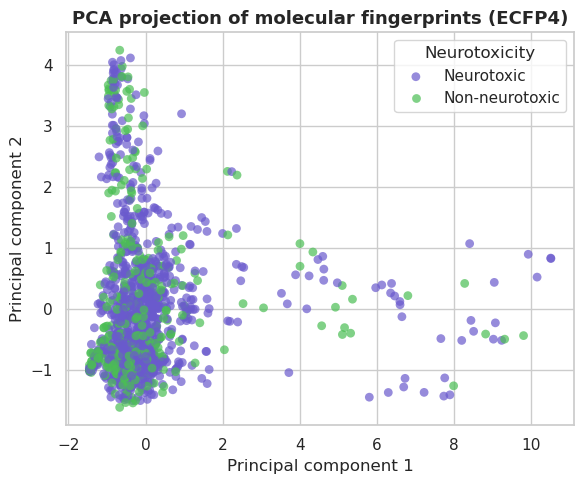

Cumulative explained variance: 9.52%


In [14]:
# ############################################################ #
# PCA projection of molecular fingerprints (ECFP4)             #
# ############################################################ #

# --- Dimensionality reduction (2D PCA projection) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# --- Scatter plot ---
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=meta["neurotoxic"],
    palette=[green_light, violet_main],
    alpha=0.7, s=40, edgecolor="none"
)
plt.title("PCA projection of molecular fingerprints (ECFP4)", fontsize=13, weight="bold")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend(title="Neurotoxicity", labels=["Neurotoxic", "Non-neurotoxic"])
plt.tight_layout()
plt.show()

# --- Variance explained summary ---
explained_var = pca.explained_variance_ratio_.sum()
print(f"Cumulative explained variance: {explained_var:.2%}")


### PCA projection of ECFP4 fingerprints

#### General distribution

- Points form a **compact, overlapping cluster** near the origin (PC1≈0, PC2≈0), with a few **outliers** extending along PC1.  
- The two classes are **heavily mixed**, showing **no linear separation** in fingerprint space.

#### Chemical interpretation

- This overlap reflects that ECFP4 encodes **chemical structure**, not **biological activity** directly.  
- Neurotoxicity depends on **functional context** (e.g., receptor binding, metabolism), not simple substructure presence.  
- The fingerprints thus capture structure well, but **not the emergent toxicity signal** on their own.

#### Implications for modeling

- The PCA confirms that the **decision boundary is non-linear** justifying the use of **non-linear algorithms** (Random Forest, XGBoost, Neural Networks).  
- Dimensionality reduction techniques like **t-SNE** or **UMAP** may reveal more subtle, non-linear separations between classes.  


## III) Enriching the dataset with biological targets (ChEMBL)

To better understand the biological mechanisms behind neurotoxicity, this step enriches the chemical dataset with **biological target information** from the **ChEMBL** database.  

By adding **ChEMBL target information**, we move beyond chemical structure alone, enabling biological interpretability.  
This makes it possible to test whether **certain target families** (e.g., dopamine receptors, ion channels, mitochondrial enzymes) are **overrepresented among neurotoxic drugs**.

Each compound, already identified in **PubChem** via its **InChIKey**, is mapped to its corresponding **ChEMBL ID**.  


---

**Source:**  
- [ChEMBL Database (EMBL–EBI)](https://www.ebi.ac.uk/chembl/)  


In [15]:
# ########################################################  #
# ChEMBL enrichment: InChIKey → ChEMBL ID + targets + names #
# ########################################################  #

# --- File paths  ---
struct_path = processed_dir / "labels_with_smiles_inchikey.csv"
out_map     = processed_dir / "inchikey_to_chembl.csv"
out_targets = processed_dir / "chembl_targets_raw.csv"
out_names   = processed_dir / "chembl_molecule_names.csv"
cache_path  = processed_dir / "cache_inchikey_chembl.csv"

# --- HTTP session ---
session = requests.Session()
session.headers.update({
    "User-Agent": "Neurotox_project (M2 Digipharm student project)",
    "Accept": "application/json"
})

# ============================================================ #
# Mapping InChIKey → ChEMBL ID 
# ============================================================ #
def map_inchikey_to_chembl(inchikey: str) -> str | None:
    """Return the exact ChEMBL ID for a given InChIKey (structure query)."""
    url = "https://www.ebi.ac.uk/chembl/api/data/molecule.json"
    params = {"molecule_structures__standard_inchi_key": inchikey, "format": "json"}
    try:
        r = session.get(url, params=params, timeout=15)
        if r.status_code != 200:
            return None
        data = r.json()
        mols = data.get("molecules", [])
        if not mols:
            return None
        return mols[0].get("molecule_chembl_id")
    except Exception as e:
        print(f"[WARN] {inchikey}: {e}")
        return None


# ============================================================ #
# Load cache (avoid remapping already-seen InChIKeys)
# ============================================================ #
if cache_path.exists():
    cache_df = pd.read_csv(cache_path)
    cache = dict(zip(cache_df["inchikey"], cache_df["chembl_id"]))
else:
    cache = {}

# ============================================================ #
# Prepare input (unique InChIKeys per STITCH ID)
# ============================================================ #
struct_df = (
    pd.read_csv(struct_path, usecols=["stitch_id_flat", "inchikey"])
      .dropna()
      .drop_duplicates(subset=["stitch_id_flat"])
      .reset_index(drop=True)
)

n_todo = len(struct_df)
display(Markdown(f"### **Preparation**\n- Molecules to map (InChIKey → ChEMBL): **{n_todo:,}**"))

# ============================================================ #
# Map InChIKey → ChEMBL (parallel + cache)
# ============================================================ #
results = []
inchikeys = struct_df["inchikey"].dropna().unique().tolist()

def worker(ik: str) -> dict:
    if ik in cache:
        return {"inchikey": ik, "chembl_id": cache[ik]}
    chembl_id = map_inchikey_to_chembl(ik)
    cache[ik] = chembl_id
    return {"inchikey": ik, "chembl_id": chembl_id}

print(f"\nStarting ChEMBL mapping for {len(inchikeys):,} molecules...")

# 8 requests
with ThreadPoolExecutor(max_workers=8) as ex:
    futures = {ex.submit(worker, ik): ik for ik in inchikeys}
    for f in tqdm(as_completed(futures), total=len(futures), desc="Mapping InChIKey → ChEMBL", unit="molecule"):
        results.append(f.result())
        sleep(0.05)  

# Save updated cache
pd.DataFrame(list(cache.items()), columns=["inchikey", "chembl_id"]).to_csv(cache_path, index=False)

# Build mapping dataframe
map_df = pd.DataFrame(results)
map_df = map_df.merge(struct_df, on="inchikey", how="left")[["stitch_id_flat", "inchikey", "chembl_id"]]
map_df = map_df.dropna(subset=["chembl_id"]).reset_index(drop=True)
map_df.to_csv(out_map, index=False)

# ============================================================ #
# Fetch ChEMBL targets (mechanisms) for each mapped molecule
# ============================================================ #
def fetch_targets(chembl_id: str) -> pd.DataFrame:
    """Return mechanism/target records for a given molecule_chembl_id."""
    url = "https://www.ebi.ac.uk/chembl/api/data/mechanism"
    try:
        r = session.get(url, params={"molecule_chembl_id": chembl_id, "limit": 100}, timeout=25)
        if r.status_code != 200:
            return pd.DataFrame()
        data = r.json().get("mechanisms", [])
        if not data:
            return pd.DataFrame()
        df = pd.DataFrame(data)
        keep = ["molecule_chembl_id", "target_chembl_id", "target_name", "target_type", "action_type"]
        for c in keep:
            if c not in df.columns:
                df[c] = None
        return df[keep].dropna(subset=["target_chembl_id"])
    except Exception:
        return pd.DataFrame()

targets = []
for row in tqdm(map_df.itertuples(index=False), total=len(map_df), desc="Retrieving targets", unit="molecule"):
    df_t = fetch_targets(row.chembl_id)
    if not df_t.empty:
        df_t["stitch_id_flat"] = row.stitch_id_flat
        targets.append(df_t)
    sleep(0.1)

if targets:
    targets_df = pd.concat(targets, ignore_index=True)
else:
    targets_df = pd.DataFrame(columns=["stitch_id_flat", "target_chembl_id", "target_name", "target_type", "action_type"])

targets_df = targets_df.dropna(axis=1, how="all").drop_duplicates()
targets_df.to_csv(out_targets, index=False)

# ============================================================ #
# Fetch preferred molecule names from ChEMBL
# ============================================================ #
def fetch_molecule_name(chembl_id: str) -> str | None:
    """Return the preferred ChEMBL molecule name."""
    try:
        # Main endpoint
        url_main = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.json"
        r = session.get(url_main, timeout=15)
        if r.status_code == 200:
            data = r.json()
            if data.get("pref_name"):
                return data["pref_name"]

        # Legacy endpoint (fallback)
        url_old = "https://www.ebi.ac.uk/chembl/api/data/molecule.json"
        r2 = session.get(url_old, params={"molecule_chembl_id": chembl_id, "format": "json"}, timeout=15)
        if r2.status_code == 200:
            data2 = r2.json().get("molecules", [])
            if data2 and data2[0].get("pref_name"):
                return data2[0]["pref_name"]

        return None
    except Exception as e:
        print(f"[WARN] {chembl_id}: {e}")
        return None

chembl_ids = map_df["chembl_id"].dropna().unique().tolist()
print(f"\nRetrieving preferred names for {len(chembl_ids):,} molecules...")

mol_names = []
for cid in tqdm(chembl_ids, desc="Fetching molecule names", unit="molecule"):
    name = fetch_molecule_name(cid)
    mol_names.append({"chembl_id": cid, "molecule_name": name})
    sleep(0.05)

mol_names_df = pd.DataFrame(mol_names)
mol_names_df.to_csv(out_names, index=False)

# ============================================================ #
# Final report
# ============================================================ #
print("\n" + "="*70)
print(f"Completed mapping for {len(map_df):,} molecules")
print(f"Mapping file  → {out_map}")
print(f"Target data   → {out_targets}")
print(f"Molecule names→ {out_names}")
print("="*70 + "\n")


### **Preparation**
- Molecules to map (InChIKey → ChEMBL): **1,430**


Starting ChEMBL mapping for 1,430 molecules...


Retrieving targets: 100%|██████████| 938/938 [06:29<00:00,  2.41molecule/s]



Retrieving preferred names for 938 molecules...


Fetching molecule names: 100%|██████████| 938/938 [07:10<00:00,  2.18molecule/s]


Completed mapping for 938 molecules
Mapping file  → data/processed/inchikey_to_chembl.csv
Target data   → data/processed/chembl_targets_raw.csv
Molecule names→ data/processed/chembl_molecule_names.csv




### **ChEMBL Summary**
| Metric | Value |
|---------|--------|
| **Mapped molecules (→ ChEMBL ID)** | 938 |
| **Molecule–target pairs** | 457 |
| **Distinct biological targets** | 202 |
| **Molecules with ≥ 1 target** | 320 |
| **Files generated** | `inchikey_to_chembl.csv`, `chembl_targets_raw.csv`, `features_targets_onehot.csv`, `chembl_target_names.csv` |

**Data successfully enriched with ChEMBL target annotations.**


Fetching targets: 100%|██████████| 202/202 [03:24<00:00,  1.01s/target]


[OK] Target names file saved → data/processed/chembl_target_names.csv


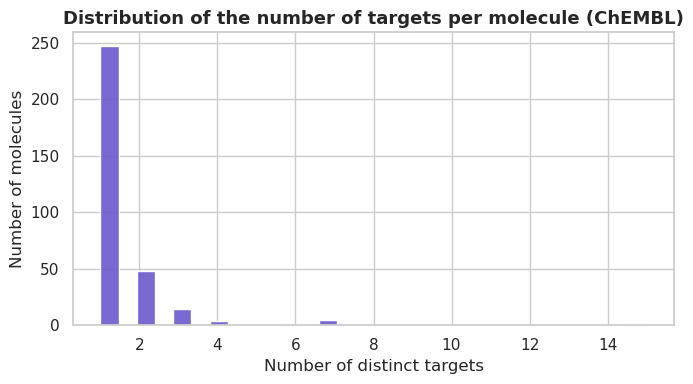

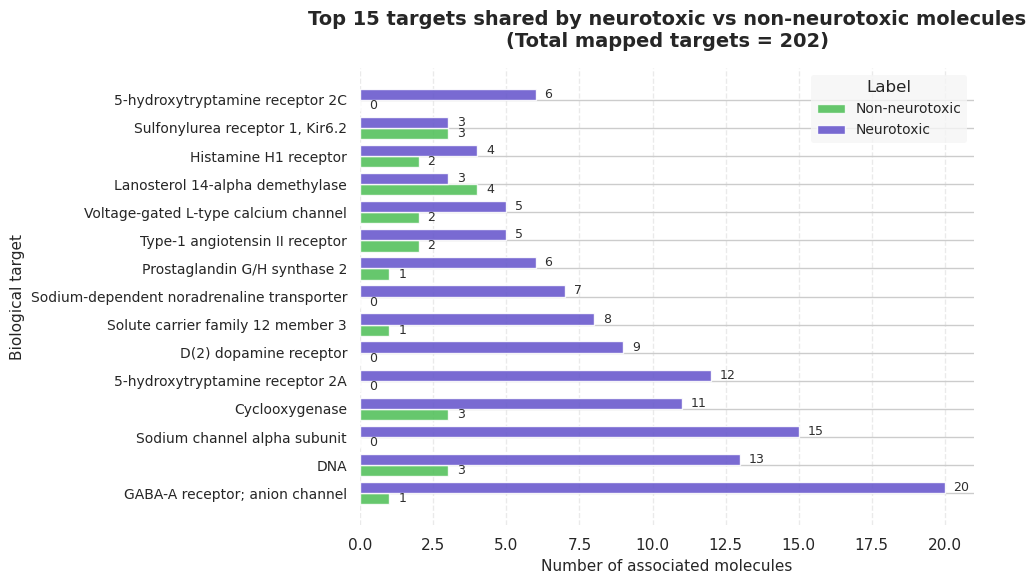

[OK] Target comparison plot saved → images/targets_neuro_vs_nonneuro_total.png


In [16]:
# ############################################################### #
# Enriched ChEMBL analysis: aligned and harmonized visualizations #
# ############################################################### #

# --- File paths  ---
out_map_path      = out_map           
out_targets_path  = out_targets      
out_onehot_path   = processed_dir / "features_targets_onehot.csv"
target_names_path = processed_dir / "chembl_target_names.csv"
labels_path       = processed_dir / "labels_neuro.csv"

# ============================================================ #
# Load and summarize data
# ============================================================ #
map_df     = pd.read_csv(out_map_path)
targets_df = pd.read_csv(out_targets_path)
labels_df  = pd.read_csv(labels_path)

n_mapped   = len(map_df)
n_pairs    = len(targets_df)
n_targets  = targets_df["target_chembl_id"].nunique()
n_with_any = targets_df["stitch_id_flat"].nunique()

display(Markdown(f"""
### **ChEMBL Summary**
| Metric | Value |
|---------|--------|
| **Mapped molecules (→ ChEMBL ID)** | {n_mapped:,} |
| **Molecule–target pairs** | {n_pairs:,} |
| **Distinct biological targets** | {n_targets:,} |
| **Molecules with ≥ 1 target** | {n_with_any:,} |
| **Files generated** | `{out_map_path.name}`, `{out_targets_path.name}`, `{out_onehot_path.name}`, `{target_names_path.name}` |

**Data successfully enriched with ChEMBL target annotations.**
"""))

# ============================================================ #
# Download or update target names and metadata
# ============================================================ #
need_update = False
if not target_names_path.exists():
    print(f"Downloading metadata for {n_targets} unique ChEMBL targets...")
    need_update = True
else:
    df_names = pd.read_csv(target_names_path)
    if "target_type" not in df_names.columns:
        print("Updating file: adding 'target_type' column...")
        need_update = True
    else:
        print(f"Existing target names file loaded → {target_names_path}")

if need_update:
    target_ids = sorted(targets_df["target_chembl_id"].dropna().unique())
    records = []
    for tid in tqdm(target_ids, desc="Fetching targets", unit="target"):
        url = f"https://www.ebi.ac.uk/chembl/api/data/target/{tid}.json"
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                d = r.json()
                records.append({
                    "target_chembl_id": tid,
                    "pref_name": d.get("pref_name") or "Unknown",
                    "organism": d.get("organism") or "",
                    "target_type": d.get("target_type") or "Unknown"
                })
        except Exception:
            pass
        sleep(0.05)

    df_names = pd.DataFrame(records)
    df_names.to_csv(target_names_path, index=False)
    print(f"[OK] Target names file saved → {target_names_path}")

# ============================================================ #
# One-hot encoding: molecule × target matrix
# ============================================================ #
if not targets_df.empty:
    bin_matrix = (
        targets_df.assign(val=1)
        .pivot_table(index="stitch_id_flat",
                     columns="target_chembl_id",
                     values="val", fill_value=0)
        .astype("uint8")
    )
    bin_matrix.to_csv(out_onehot_path)
else:
    bin_matrix = pd.DataFrame()
    bin_matrix.to_csv(out_onehot_path, index=False)

# ============================================================ #
# Distribution of the number of targets per molecule
# ============================================================ #
targets_per_mol = (
    targets_df.groupby("stitch_id_flat")["target_chembl_id"]
    .nunique()
    .reset_index(name="n_targets")
)

plt.figure(figsize=(7, 4))
sns.histplot(targets_per_mol["n_targets"], bins=30,
             color=violet_main, alpha=0.9, edgecolor="white")
plt.title("Distribution of the number of targets per molecule (ChEMBL)", fontsize=13, weight="bold")
plt.xlabel("Number of distinct targets")
plt.ylabel("Number of molecules")
plt.tight_layout()
plt.show()

# ============================================================ #
# Comparison: neurotoxic vs non-neurotoxic target profiles
# ============================================================ #
merged_df = (
    targets_df.merge(map_df, on="stitch_id_flat", how="left")
              .merge(labels_df[["stitch_id_flat", "neurotoxic"]],
                     on="stitch_id_flat", how="left")
)

# Keep only rows with valid targets
merged_df = merged_df.dropna(subset=["target_chembl_id"])

# Count distinct molecules per target per neurotoxicity label
counts = (
    merged_df.groupby(["target_chembl_id", "neurotoxic"])["stitch_id_flat"]
    .nunique()
    .unstack(fill_value=0)
    .rename(columns={0: "Non-neurotoxic", 1: "Neurotoxic"})
)

# Compute totals and extract top 15 targets
counts["Total"] = counts["Non-neurotoxic"] + counts["Neurotoxic"]
top_targets = counts.sort_values("Total", ascending=False).head(15)

# Add target names 
if "pref_name" in df_names.columns:
    top_targets = (
        top_targets.merge(df_names[["target_chembl_id", "pref_name"]],
                          left_index=True, right_on="target_chembl_id", how="left")
        .set_index("pref_name")
        .drop(columns="target_chembl_id")
    )
else:
    top_targets.index.name = "Biological target"

# ============================================================ #
# Visualization: top 15 targets by neurotoxicity class
# ============================================================ #
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
y = np.arange(len(top_targets))

ax.barh(y - bar_width/2, top_targets["Non-neurotoxic"], height=bar_width,
        color=green_light, label="Non-neurotoxic", alpha=0.85)
ax.barh(y + bar_width/2, top_targets["Neurotoxic"], height=bar_width,
        color=violet_main, label="Neurotoxic", alpha=0.9)

# Label each bar with its count
for i, (non_neuro, neuro) in enumerate(zip(top_targets["Non-neurotoxic"], top_targets["Neurotoxic"])):
    ax.text(non_neuro + 0.3, i - bar_width/2, f"{non_neuro}", va="center", fontsize=9, color="#2E2E2E")
    ax.text(neuro + 0.3, i + bar_width/2, f"{neuro}", va="center", fontsize=9, color="#2E2E2E")

# Axis and title setup
total_targets = counts.shape[0]
ax.set_yticks(y)
ax.set_yticklabels(top_targets.index, fontsize=10)
ax.set_xlabel("Number of associated molecules", fontsize=11)
ax.set_ylabel("Biological target", fontsize=11)
ax.set_title(
    f"Top 15 targets shared by neurotoxic vs non-neurotoxic molecules\n"
    f"(Total mapped targets = {total_targets:,})",
    fontsize=14, weight="bold", pad=15
)

legend = ax.legend(frameon=True, loc="upper right", fontsize=10, title="Label")
legend.get_frame().set_facecolor("#F5F5F5")
legend.get_frame().set_edgecolor("none")
sns.despine(left=True, bottom=True)
ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()

# Save figure
save_path = images_dir / "targets_neuro_vs_nonneuro_total.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"[OK] Target comparison plot saved → {save_path}")




### **ChEMBL target enrichment summary**

The dataset was successfully **enriched with ChEMBL target annotations**, linking **938 molecules** to **202 distinct biological targets** across **457 molecule–target pairs**.  
Among these, **320 molecules** have at least one known target.

#### Distribution of targets per molecule

- Most compounds have **only one target**, with a steep drop-off for higher counts (up to ~6–8 targets).  
- This reflects a predominance of **monotarget drugs**, while a few **polypharmacological molecules** (e.g., antipsychotics, anesthetics) interact with multiple targets.  
- The coverage is **biologically coherent and sparse**, as expected from experimental ChEMBL data (~27% of molecules with known targets).

#### Top 15 shared targets (neurotoxic vs non-neurotoxic)

- **Neurotoxic molecules** are enriched for **CNS-related targets** such as **GABA-A**, **D2 dopamine**, **5-HT2A**, and **voltage-gated ion channels**.  
- **Non-neurotoxic molecules** more often act on **peripheral or metabolic targets** (e.g., COX, DNA, androgen receptor).

#### Implications for modeling

- The **ChEMBL layer adds a mechanistic dimension**: fingerprints capture structure, while targets describe **pharmacological action**.  
- Combining both feature spaces (ECFP4 + ChEMBL) will enhance model interpretability and biological relevance.  
- Sparse coverage is normal but manageable. **Chemical fingerprints remain the core features**, with ChEMBL targets as a **biologically informative complement**.


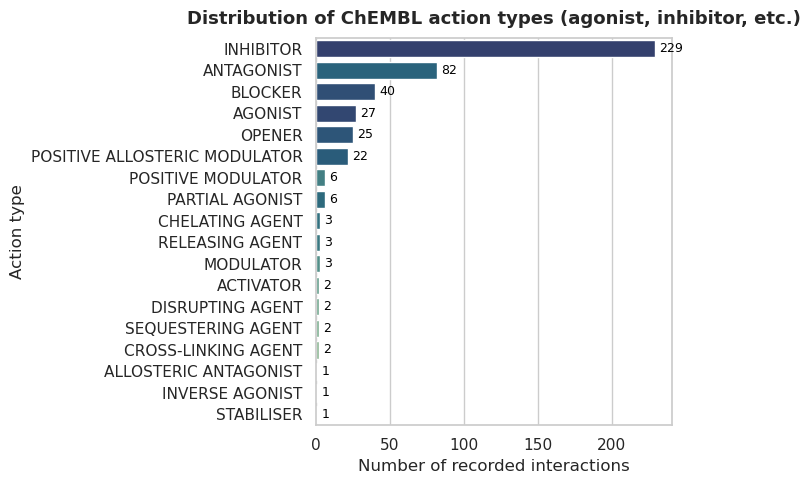

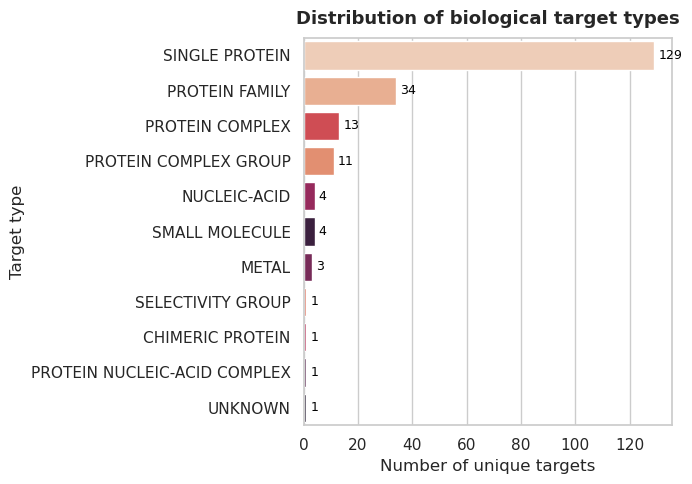

In [17]:
# ############################################################## #
# ChEMBL target characterization — actions and target types     #
# ############################################################# #

# --- Load data ---
targets_df = pd.read_csv(processed_dir / "chembl_targets_raw.csv")
names_df   = pd.read_csv(processed_dir / "chembl_target_names.csv")

# ============================================================ #
# Distribution of target action types (e.g., inhibitor, agonist)
# ============================================================ #
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    data=targets_df.dropna(subset=["action_type"]),
    y="action_type",
    order=targets_df["action_type"].value_counts().index,
    hue="action_type",           
    legend=False,
    palette="crest_r"
)

plt.title("Distribution of ChEMBL action types (agonist, inhibitor, etc.)",
          fontsize=13, weight="bold", pad=10)
plt.xlabel("Number of recorded interactions")
plt.ylabel("Action type")

# Display count values at the end of each bar
for c in ax.containers:
    ax.bar_label(c, fmt="%d", label_type="edge", padding=3, fontsize=9, color="black")

plt.tight_layout()
plt.show()

# ============================================================ #
# Distribution of biological target types
# ============================================================ #
if "target_type" in names_df.columns and names_df["target_type"].notna().any():
    plt.figure(figsize=(7, 5))
    ax = sns.countplot(
        data=names_df.dropna(subset=["target_type"]),
        y="target_type",
        order=names_df["target_type"].value_counts().index,
        hue="target_type",
        legend=False,
        palette="rocket_r"
    )

    plt.title("Distribution of biological target types",
              fontsize=13, weight="bold", pad=10)
    plt.xlabel("Number of unique targets")
    plt.ylabel("Target type")

    for c in ax.containers:
        ax.bar_label(c, fmt="%d", label_type="edge", padding=3, fontsize=9, color="black")

    plt.tight_layout()
    plt.show()


### **ChEMBL target characterization**

#### Distribution of ChEMBL action types

- The dataset is dominated by **inhibitor** interactions (≈50%), followed by **antagonist**, **blocker**, and **agonist**.  
- This reflects typical pharmacology, most drugs act by **blocking or inhibiting** a biological function (e.g., enzyme or receptor).  
- The variable `action_type` is **categorical and incomplete**, useful for **contextual analysis** but not for direct modeling.

#### Distribution of biological target types

- About **two-thirds of all targets** are **single proteins**, followed by **protein families** and **complexes**.   
- While not directly used as features, these summaries **validate the biological relevance** and focus of the target dataset.


===== META_LABELS.CSV =====
stitch_id_flat                drug_name  neurotoxic
  CID100000085                carnitine           1
  CID100000119       gamma-aminobutyric           0
  CID100000137         5-aminolevulinic           1
  CID100000143               leucovorin           1
  CID100000146 5-methyltetrahydrofolate           0
...

===== FEATURES_TARGETS_ONEHOT.CSV =====
stitch_id_flat  CHEMBL1641347  CHEMBL1641348  CHEMBL1780  CHEMBL1786  CHEMBL1790  CHEMBL1798  CHEMBL1801  CHEMBL1829  CHEMBL1839  CHEMBL1849  CHEMBL1861  CHEMBL1862  CHEMBL1865  CHEMBL1871  CHEMBL1872  CHEMBL1873  CHEMBL1874  CHEMBL1875  CHEMBL1876  CHEMBL1886  CHEMBL1893  CHEMBL1898  CHEMBL1899  CHEMBL1906  CHEMBL1908  CHEMBL1911  CHEMBL1913  CHEMBL1929  CHEMBL1935  CHEMBL1936  CHEMBL1937  CHEMBL1939  CHEMBL1941  CHEMBL1951  CHEMBL1952  CHEMBL1966  CHEMBL1973  CHEMBL1978  CHEMBL1980  CHEMBL1983  CHEMBL1994  CHEMBL1997  CHEMBL2011  CHEMBL2019  CHEMBL2023  CHEMBL203  CHEMBL2033  CHEMBL204  CHEMBL2041  CHEMBL2


### **Final fusion of chemical and biological features**

**File dimensions:**
- `meta` → `1,430 × 3`
- `onehot` → `320 × 203`
- `ECFP4` → `1,430 × 2048`

**Merged dataset:**
- Labels + targets → `1,430 × 205`
- Final dataset saved → `1,430 × 2253` 

---

**Coherence checks:**
- `neurotoxic` label counts → {1: 1059, 0: 371}
- Missing values: `0`
- Duplicates on 'stitch_id_flat': `0`

---

**Feature composition:**
- Chemical (ECFP4): **2048**
- Biological (ChEMBL targets): **202**
- Labels: `{'neurotoxic'}`


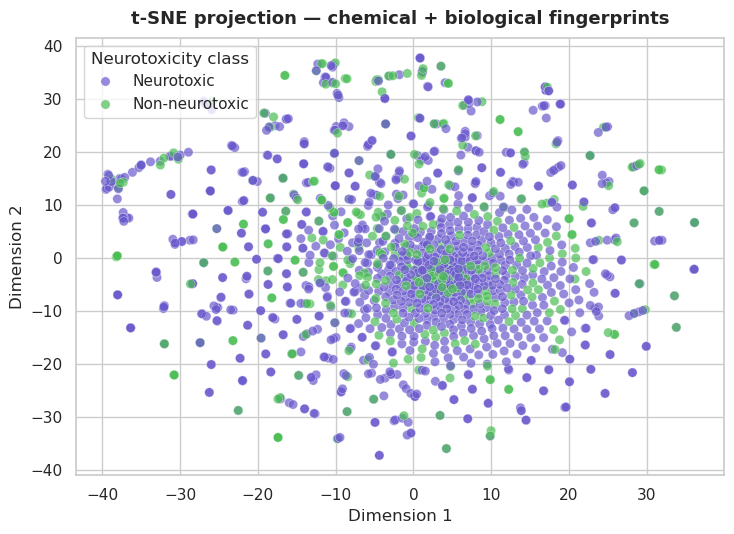

In [18]:
# ############################################################# #
# Final dataset fusion: chemical + biological feature matrices  #
# ############################################################# #

# --- File paths ---
meta_path   = processed_dir / "meta_labels.csv"          # metadata (molecule info + neurotoxicity)
onehot_path = processed_dir / "features_targets_onehot.csv"  # biological targets 
ecfp4_path  = processed_dir / "X_ECFP4_2048.npy"             # chemical fingerprints 

# --- Load data ---
meta_df   = pd.read_csv(meta_path)
onehot_df = pd.read_csv(onehot_path)
X         = np.load(ecfp4_path)

# ============================================================ #
# Quick overview of input files
# ============================================================ #

print("===== META_LABELS.CSV =====")
with pd.option_context('display.max_rows', 5, 'display.max_columns', 6, 'display.width', 1000):
    print(meta_df.head().to_string(index=False))
print("...\n")

print("===== FEATURES_TARGETS_ONEHOT.CSV =====")
with pd.option_context('display.max_rows', 5, 'display.max_columns', 10, 'display.width', 1000):
    print(onehot_df.head().to_string(index=False))
print("...\n")

print("===== X_ECFP4_2048.NPY =====")
print(f"Type: {type(X)}, dtype: {X.dtype}, shape: {X.shape}")
print("\nExample of binary fingerprint vectors (0/1):")
print(pd.DataFrame(X[:5, :15]).to_string(index=False, header=[f"b{i}" for i in range(15)]))
print("...\n")

# ============================================================ #
# Merge datasets (meta + one-hot + ECFP4)
# ============================================================ #

assert "stitch_id_flat" in meta_df.columns
assert "stitch_id_flat" in onehot_df.columns

merged_df = meta_df.merge(onehot_df, on="stitch_id_flat", how="left").fillna(0)
X_df = pd.DataFrame(X, columns=[f"ECFP4_{i}" for i in range(X.shape[1])])
final_df = pd.concat([merged_df.reset_index(drop=True), X_df], axis=1)

final_path = processed_dir / "data_final.csv"
final_df.to_csv(final_path, index=False)

# Identify feature groups
cols_chem = [c for c in final_df.columns if c.startswith("ECFP4_")]
cols_bio  = [c for c in final_df.columns if c.startswith("CHEMBL")]

# ============================================================ #
# Summary and consistency checks
# ============================================================ #

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

info_text = f"""
### **Final fusion of chemical and biological features**

**File dimensions:**
- `meta` → `{meta_df.shape[0]:,} × {meta_df.shape[1]}`
- `onehot` → `{onehot_df.shape[0]:,} × {onehot_df.shape[1]}`
- `ECFP4` → `{X.shape[0]:,} × {X.shape[1]}`

**Merged dataset:**
- Labels + targets → `{merged_df.shape[0]:,} × {merged_df.shape[1]}`
- Final dataset saved → `{final_df.shape[0]:,} × {final_df.shape[1]}` 

---

**Coherence checks:**
- `neurotoxic` label counts → {final_df["neurotoxic"].value_counts().to_dict()}
- Missing values: `{final_df.isna().sum().sum()}`
- Duplicates on 'stitch_id_flat': `{final_df.duplicated('stitch_id_flat').sum()}`

---

**Feature composition:**
- Chemical (ECFP4): **{len(cols_chem)}**
- Biological (ChEMBL targets): **{len(cols_bio)}**
- Labels: `{set(final_df.columns) & {'neurotoxic'}}`
"""
display(Markdown(textwrap.dedent(info_text)))

# ============================================================ #
# t-SNE visualization: combined chemical + biological features  #
# ============================================================ #

X_all = final_df[cols_chem + cols_bio].astype(float)
X_all = StandardScaler().fit_transform(X_all)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    n_iter=1500,
    init="pca"
)
embedding = tsne.fit_transform(X_all)

plt.figure(figsize=(7.5, 5.5))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=final_df["neurotoxic"].map({0: "Non-neurotoxic", 1: "Neurotoxic"}),
    palette=[violet_main, green_light],
    alpha=0.7,
    s=45,
    edgecolor="white",
    linewidth=0.3
)
plt.title("t-SNE projection — chemical + biological fingerprints", fontsize=13, weight="bold", pad=10)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Neurotoxicity class", loc="upper left", frameon=True)
plt.tight_layout()
plt.show()


### **t-SNE projection : combined chemical + biological fingerprints**

The t-SNE projection visualizes the **non-linear structure** of the dataset by embedding the high-dimensional features  (ECFP4 chemical fingerprints + ChEMBL biological targets) into a **2D space**.

t-SNE is used to explore **non-linear relationships** that PCA cannot capture,  
  helping identify **latent clusters or manifolds** based on structural and pharmacological similarity.  

It provides an intuitive overview of how **chemical and biological features jointly organize** the molecular space.

#### Observations

- The projection forms a **dense central cluster** with diffuse edges.
- **Neurotoxic ** and **non-neurotoxic** molecules remain **strongly overlapping**, confirming that  **neurotoxicity is not linearly separable** even when biological profiles are added.  
- A few **peripheral groups** may correspond to structurally or pharmacologically distinct subsets.

#### Interpretation and modeling implications

- The overlap indicates that **toxicity emerges from complex, multi-factorial patterns**,  
  not from a single chemical or target signature.  
- Combining **chemical descriptors** with **target-based features** remains relevant:  
  while separability is low in 2D, these complementary views can improve **non-linear classifiers**  (e.g., Random Forest, XGBoost, neural networks).  
- t-SNE thus serves mainly as a **diagnostic visualization** to verify feature consistency and dataset structure before model training.


Dataset loaded successfully: 1430 rows × 2253 columns

Chemical columns (ECFP4): 2048
Biological columns (ChEMBL): 202
Meta/label columns: ['stitch_id_flat', 'drug_name', 'neurotoxic']
ECFP4 fingerprints correctly detected (2048 bits).

===== FINAL DATASET (first columns preview) =====


stitch_id_flat                 drug_name  neurotoxic  CHEMBL1641347  CHEMBL1641348  CHEMBL1780  CHEMBL1786  CHEMBL1790
0   CID100000085                 carnitine           1            0.0            0.0         0.0         0.0         0.0
1   CID100000119        gamma-aminobutyric           0            0.0            0.0         0.0         0.0         0.0
2   CID100000137          5-aminolevulinic           1            0.0            0.0         0.0         0.0         0.0
3   CID100000143                leucovorin           1            0.0            0.0         0.0         0.0         0.0
4   CID100000146  5-methyltetrahydrofolate           0            0.0            0.0         0.0         0.0         0.0


Dataset dimensions: (1430, 2253)

Quick statistical overview:


stitch_id_flat drug_name   neurotoxic  CHEMBL1641347  CHEMBL1641348  \
count            1430      1430  1430.000000    1430.000000    1430.000000   
unique           1430      1347          NaN            NaN            NaN   
top      CID100000085    sodium          NaN            NaN            NaN   
freq                1        11          NaN            NaN            NaN   
mean              NaN       NaN     0.740559       0.000699       0.000699   
std               NaN       NaN     0.438481       0.026444       0.026444   

         CHEMBL1780  
count   1430.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean       0.004895  
std        0.069818


Summary of numerical columns:


count    mean     std  min  max
neurotoxic     1430.0  0.7406  0.4385  0.0  1.0
CHEMBL1641347  1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1641348  1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1780     1430.0  0.0049  0.0698  0.0  1.0
CHEMBL1786     1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1790     1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1798     1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1801     1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1829     1430.0  0.0007  0.0264  0.0  1.0
CHEMBL1839     1430.0  0.0021  0.0458  0.0  1.0


Summary of categorical columns:


count unique           top
stitch_id_flat  1430   1430  CID100000085
drug_name       1430   1347        sodium


Example record found for molecule: **Aripiprazole**
→ 2253 columns total


stitch_id_flat     drug_name  neurotoxic  CHEMBL1641347  CHEMBL1641348  \
977   CID100060795  aripiprazole           1            0.0            0.0   

     CHEMBL1780  CHEMBL1786  CHEMBL1790  CHEMBL1798  CHEMBL1801  ...  \
977         0.0         0.0         0.0         0.0         0.0  ...   

     ECFP4_2038  ECFP4_2039  ECFP4_2040  ECFP4_2041  ECFP4_2042  ECFP4_2043  \
977           0           0           0           0           0           0   

     ECFP4_2044  ECFP4_2045  ECFP4_2046  ECFP4_2047  
977           0           0           0           0  

[1 rows x 2253 columns]


Mean fingerprint density (proportion of active bits):
→ Average per molecule: 0.0227
→ Average per bit (global): 0.0227


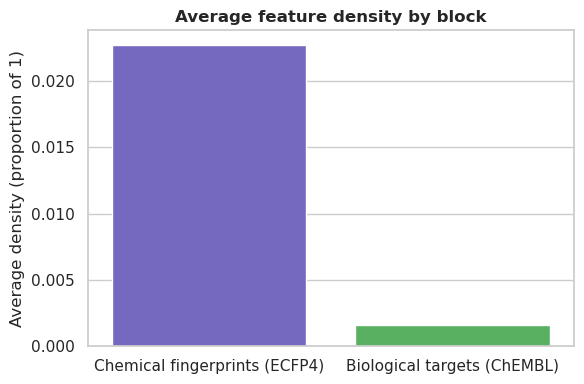

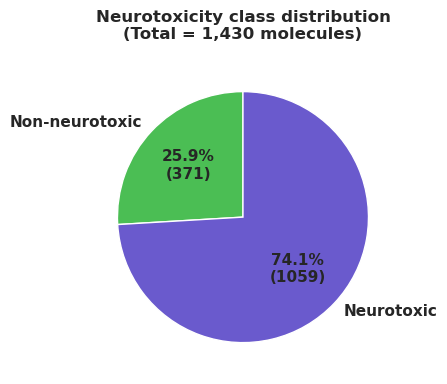


Figure saved successfully → images/class_distribution_neurotoxicity.png


In [19]:
# ############################################################# #
# Visualization and exploration of the final merged dataset     #
# ############################################################# #

# --- Load final dataset ---
final_path = processed_dir / "data_final.csv"
final_df = pd.read_csv(final_path)

print(f"Dataset loaded successfully: {final_df.shape[0]} rows × {final_df.shape[1]} columns\n")

# ============================================================ #
# Identify column groups
# ============================================================ #
cols_chem = [c for c in final_df.columns if c.startswith("ECFP4_")]
cols_bio  = [c for c in final_df.columns if c.startswith("CHEMBL")]
cols_meta = [c for c in final_df.columns if not c.startswith(("CHEMBL", "ECFP4_"))]

print(f"Chemical columns (ECFP4): {len(cols_chem)}")
print(f"Biological columns (ChEMBL): {len(cols_bio)}")
print(f"Meta/label columns: {cols_meta}")

if len(cols_chem) == 2048:
    print("ECFP4 fingerprints correctly detected (2048 bits).")
else:
    print("Unexpected number of chemical fingerprint columns!")

# ============================================================ #
# Quick tabular preview
# ============================================================ #
print("\n===== FINAL DATASET (first columns preview) =====")
with pd.option_context('display.max_rows', 5, 'display.max_columns', 8, 'display.width', 1000):
    display(final_df.head().iloc[:, :8])

print("\nDataset dimensions:", final_df.shape)

print("\nQuick statistical overview:")
with pd.option_context('display.max_columns', 6):
    display(final_df.describe(include="all").iloc[:6, :6])

# ============================================================ #
# Detailed numeric and categorical summaries
# ============================================================ #
desc_num = final_df.describe(include=[float, int]).T
desc_num = desc_num.round(4)[["count", "mean", "std", "min", "max"]]
print("\nSummary of numerical columns:")
display(desc_num.head(10))

desc_cat = final_df.describe(include=["object"]).T
desc_cat = desc_cat.drop(columns=["freq"], errors="ignore")
print("\nSummary of categorical columns:")
display(desc_cat)

# ============================================================ #
# Example lookup: display a specific molecule (e.g. aripiprazole)
# ============================================================ #
query_name = "aripiprazole"
row_example = final_df[final_df["drug_name"].str.lower().str.contains(query_name.lower(), na=False)]

if not row_example.empty:
    print(f"\nExample record found for molecule: **{query_name.title()}**")
    print(f"→ {row_example.shape[1]} columns total")
    display(row_example)
else:
    print(f"No molecule found matching '{query_name}'. Please check the spelling.")

# ============================================================ #
# Global statistics on chemical fingerprint density
# ============================================================ #
mean_per_molecule = final_df[cols_chem].mean(axis=1).mean()
mean_per_bit = final_df[cols_chem].mean().mean()

print("\nMean fingerprint density (proportion of active bits):")
print(f"→ Average per molecule: {mean_per_molecule:.4f}")
print(f"→ Average per bit (global): {mean_per_bit:.4f}")

# ============================================================ #
# Average density of chemical vs biological features
# ============================================================ #
density_chem = final_df[cols_chem].mean().mean()
density_bio  = final_df[cols_bio].mean().mean()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=["Chemical fingerprints (ECFP4)", "Biological targets (ChEMBL)"],
    y=[density_chem, density_bio],
    palette=[violet_main, green_light]
)
plt.ylabel("Average density (proportion of 1)")
plt.title("Average feature density by block", weight="bold")
plt.tight_layout()
plt.show()

# ============================================================ #
# Neurotoxicity class distribution                              #
# ============================================================ #

images_dir.mkdir(exist_ok=True)
save_path = images_dir / "class_distribution_neurotoxicity.png"

plt.figure(figsize=(4.5, 4))

# Compute class counts
class_counts = final_df["neurotoxic"].value_counts().sort_index()
labels = ["Non-neurotoxic", "Neurotoxic"]
colors = [green_light, violet_main]

# Handle inverted order if needed
if class_counts.index.tolist() == [1, 0]:
    labels = labels[::-1]
    colors = colors[::-1]
    class_counts = class_counts[::-1]

total = class_counts.sum()

# Percentage + absolute number label
def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

# --- Plot pie chart ---
wedges, texts, autotexts = plt.pie(
    class_counts,
    autopct=autopct_format,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 11, 'weight': 'bold'}
)

plt.title(
    f"Neurotoxicity class distribution\n"
    f"(Total = {total:,} molecules)",
    weight="bold",
    pad=15
)

plt.ylabel("")
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()

print(f"\nFigure saved successfully → {save_path}")




### **Dataset overview : feature density and class balance**

#### Average feature density by block

- The **chemical fingerprints (ECFP4)** show an average density of **≈ 0.022**, meaning that only **2.2 % of the 2048 bits** are active per molecule  
  → roughly **45 substructural features** per compound.  
  This level of sparsity is **typical and desirable** for ECFP4, ensuring a **rich yet non-redundant** chemical encoding.  

- The **biological target features (ChEMBL)** have a much lower density (**≈ 0.001–0.002**),  
  meaning that most molecules are linked to **1–2 targets** among 200+.  
  This confirms that the **molecule × target matrix** is highly sparse — reflecting **limited experimental annotations** but **realistic pharmacological specificity**.


#### Neurotoxicity class distribution

- The dataset contains **1,430 molecules**, with a **class imbalance**:  
  **74 % neurotoxic (1,059)** vs **26 % non-neurotoxic (371)**.  
- This reflects the **data bias** in toxicological sources (more known toxic compounds).  
- For modeling, this imbalance will require **resampling** (e.g., SMOTE, class weights) to prevent bias toward the majority (neurotoxic) class.

#### Summary

Overall, the dataset combines a **chemically informative but sparse ECFP4 block**  
with a **biologically relevant yet incomplete ChEMBL layer**,  
providing a **realistic foundation for neurotoxicity prediction** using robust, imbalance-aware ML methods.


# IV) Pharmacological enrichment: regulatory status of molecules (ChEMBL)

Enrichment of pharmacological metadata (status, phase, withdrawal, approval year), for descriptive and exploratory purposes only, not intended for machine learning.

In [23]:
# #############################################################  #
# Pharmacological enrichment — regulatory status from ChEMBL    #
# #############################################################  #

import time 

map_path   = processed_dir / "inchikey_to_chembl.csv"
status_out = processed_dir / "chembl_status.csv"

map_df = pd.read_csv(map_path)
chembl_ids = map_df["chembl_id"].dropna().unique()

print(f"\nMolecules to query from ChEMBL: {len(chembl_ids):,}\n")

# ============================================================ #
# ChEMBL API session setup
# ============================================================ #
session = requests.Session()
session.headers.update({"User-Agent": "Neurotox_project (Master Digipharm student project)"})

# ============================================================ #
# Function to retrieve regulatory and pharmacological status 
# ============================================================ #
def fetch_chembl_status(chembl_id: str) -> dict | None:
    """Query ChEMBL API for molecule status and metadata."""
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.json"
    try:
        r = session.get(url, timeout=20)
        if r.status_code != 200:
            return None
        js = r.json()
        return {
            "chembl_id": chembl_id,
            "max_phase": js.get("max_phase"),
            "withdrawn_flag": js.get("withdrawn_flag"),
            "first_approval": js.get("first_approval"),
            "pref_name": js.get("pref_name"),
        }
    except Exception:
        return None

# ============================================================ #
# Download statuses 
# ============================================================ #
results = []
print("Fetching molecule statuses from ChEMBL API...\n")

for cid in tqdm(chembl_ids, desc="Downloading status", unit="molecule"):
    info = fetch_chembl_status(cid)
    if info:
        results.append(info)
    time.sleep(0.05)  

# ============================================================ #
# Build dataframe and save
# ============================================================ #
status_df = pd.DataFrame(results)
n_ok = len(status_df)
n_total = len(chembl_ids)

status_df.to_csv(status_out, index=False)

# ============================================================ #
# Summary report
# ============================================================ #
display(Markdown(f"""
---
### **ChEMBL status retrieval summary**
| Information | Value |
|--------------|--------|
| **Total molecules queried** | {n_total:,} |
| **Successful records retrieved** | {n_ok:,} |
| **Output file** | `{status_out.name}` |
---
"""))

print("Preview of the generated file:")
display(status_df.head())


Molecules to query from ChEMBL: 938

Fetching molecule statuses from ChEMBL API...




---
### **ChEMBL status retrieval summary**
| Information | Value |
|--------------|--------|
| **Total molecules queried** | 938 |
| **Successful records retrieved** | 938 |
| **Output file** | `chembl_status.csv` |
---


Preview of the generated file:


chembl_id max_phase  withdrawn_flag  first_approval  \
0  CHEMBL2220614      None           False             NaN   
1       CHEMBL96       1.0           False             NaN   
2  CHEMBL1620698      None           False             NaN   
3    CHEMBL69905      None           False             NaN   
4      CHEMBL601       4.0           False          1999.0   

                 pref_name  
0                     None  
1  GAMMA-AMINOBUTYRIC ACID  
2                     None  
3                     None  
4      AMINOLEVULINIC ACID

max_phase → indicates whether the compound is in clinical phase 1–4 or still experimental (4 = approved drug)

withdrawn_flag → True if the compound has been withdrawn from the market

first_approval → year of first market approval

pref_name → preferred or common name of the compound

Final merged dataset: 938 rows × 9 columns


stitch_id_flat                     inchikey      chembl_id  max_phase  \
0   CID100024841  XMBWDFGMSWQBCA-UHFFFAOYSA-N  CHEMBL1233550       -1.0   
1   CID100005726  HBOMLICNUCNMMY-UHFFFAOYSA-N   CHEMBL178240        NaN   
2   CID104659568  JRURYQJSLYLRLN-UHFFFAOYSA-N  CHEMBL5305350        NaN   
3   CID100071436  IYGXEHDCSOYNKY-UHFFFAOYSA-N  CHEMBL2138280        NaN   
4   CID100005719  HUNXMJYCHXQEGX-UHFFFAOYSA-N     CHEMBL1521        4.0   

   withdrawn_flag  first_approval pref_name   drug_name  neurotoxic  
0           False             NaN    IODIDE      iodide           1  
1           False             NaN       NaN  zidovudine           1  
2           False             NaN       NaN  entacapone           1  
3           False             NaN       NaN    Lutalyse           1  
4           False          1999.0  ZALEPLON    zaleplon           1

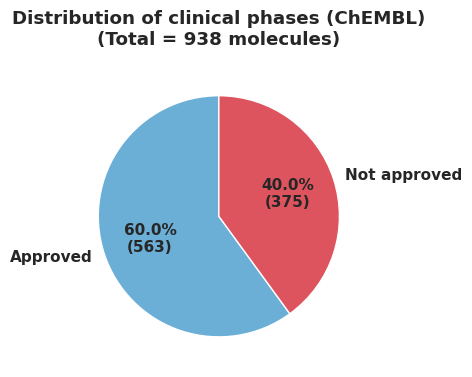

Figure saved successfully → images/distribution_clinical_phases.png

Clinical phase distribution:
 - Approved       :   563 ( 60.0%)
 - Not approved   :   375 ( 40.0%)
 - Total          :   938


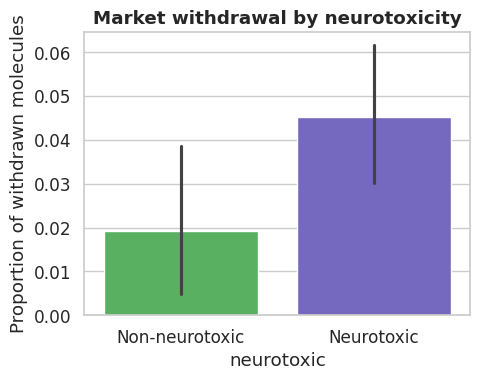

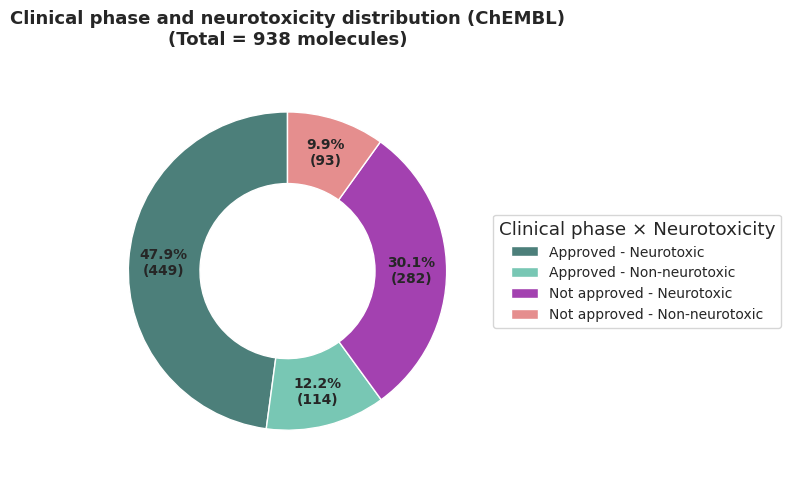

In [ ]:
# ############################################################# #
# Descriptive analysis — Regulatory status of molecules (ChEMBL)
# ############################################################# #

# --- Load data ---
labels_df  = pd.read_csv(processed_dir / "meta_labels.csv")
mapping_df = pd.read_csv(processed_dir / "inchikey_to_chembl.csv")
status_df  = pd.read_csv(processed_dir / "chembl_status.csv")

# --- Merge all sources ---
merged_df = (
    mapping_df.merge(status_df, on="chembl_id", how="left")
              .merge(labels_df, on="stitch_id_flat", how="left")
)

print(f"Final merged dataset: {merged_df.shape[0]} rows × {merged_df.shape[1]} columns")
display(merged_df.head())

# ============================================================ #
# Cleaning and formatting
# ============================================================ #
merged_df["withdrawn_flag"] = merged_df["withdrawn_flag"].astype(str).replace({"True": True, "False": False})
merged_df["max_phase"] = pd.to_numeric(merged_df["max_phase"], errors="coerce").fillna(0).astype(int)
merged_df["first_approval"] = pd.to_numeric(merged_df["first_approval"], errors="coerce")


# ============================================================ #
# Clinical phase distribution 
# ============================================================ #

images_dir.mkdir(exist_ok=True)
save_path = images_dir / "distribution_clinical_phases.png"

labels_pie = ["Approved", "Not approved"]
sizes = [(merged_df["max_phase"] == 4).sum(), (merged_df["max_phase"] < 4).sum()]
colors = [blue_approved, red_not_approved]
total = sum(sizes)

def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

plt.figure(figsize=(4.5, 4))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels_pie,
    autopct=autopct_format,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 11, 'weight': 'bold'}
)

plt.title(
    f"Distribution of clinical phases (ChEMBL)\n"
    f"(Total = {total:,} molecules)",
    weight="bold",
    pad=15
)
plt.ylabel("")
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()

print(f"Figure saved successfully → {save_path}")

print("\nClinical phase distribution:")
for label, count in zip(labels_pie, sizes):
    pct = count / total * 100
    print(f" - {label:<15}: {count:>5} ({pct:>5.1f}%)")
print(f" - {'Total':<15}: {total:>5}")

# ============================================================ #
# Market withdrawal rate by neurotoxicity
# ============================================================ #
plt.figure(figsize=(5, 4))
sns.barplot(
    data=merged_df,
    x="neurotoxic",
    y=merged_df["withdrawn_flag"].astype(float),
    palette=[green_light, violet_main]
)
plt.xticks([0, 1], ["Non-neurotoxic", "Neurotoxic"])
plt.ylabel("Proportion of withdrawn molecules")
plt.title("Market withdrawal by neurotoxicity", weight="bold")
plt.tight_layout()
plt.show()

# ============================================================ #
# Clinical phase × Neurotoxicity 
# ============================================================ #

save_path = images_dir / "distribution_clinical_phases_neurotoxicity.png"

# --- Color palette (using setup variables) ---
colors = {
    "Approved - Neurotoxic": teal_dark_toxic,
    "Approved - Non-neurotoxic": teal_light_non_tox,
    "Not approved - Neurotoxic": violet_red_toxic,
    "Not approved - Non-neurotoxic": rose_light_non_tox
}

# Example distribution (to be updated dynamically)
labels_pie = list(colors.keys())
sizes = [449, 114, 282, 93]  
total = sum(sizes)

def autopct_format(pct):
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

fig, ax = plt.subplots(figsize=(7.5, 5))

wedges, texts, autotexts = ax.pie(
    sizes,
    autopct=autopct_format,
    startangle=90,
    colors=[colors[l] for l in labels_pie],
    pctdistance=0.78,
    wedgeprops=dict(width=0.45, edgecolor='white'),
    textprops={'fontsize': 10, 'weight': 'bold'}
)

# Inner circle (donut style)
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
ax.add_artist(centre_circle)

# Legend
legend_elements = [Patch(facecolor=colors[label], label=label) for label in labels_pie]
ax.legend(
    handles=legend_elements,
    title="Clinical phase × Neurotoxicity",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

# Title and save
ax.set_title(
    f"Clinical phase and neurotoxicity distribution (ChEMBL)\n"
    f"(Total = {total:,} molecules)",
    fontsize=13,
    weight="bold",
    pad=20
)

plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()


### **Clinical phases and neurotoxicity insights**

- Among the **938 mapped molecules**, about **60% are approved drugs**, while **40% were never approved** 
- The **withdrawal analysis** shows that **neurotoxic compounds** are roughly **twice as likely** to have been **withdrawn from the market**, highlighting a clear link between **CNS toxicity** and **regulatory failure**.  
- When combining approval status and toxicity, most **approved molecules** are still **neurotoxic**, but a significant fraction of **non-approved drugs** also show **neurotoxic potential**, suggesting that **neurotoxicity remains a major barrier** during clinical development.  
- Overall, these trends emphasize that **neurotoxic risk is a key determinant** of clinical success and post-marketing safety in drug development.


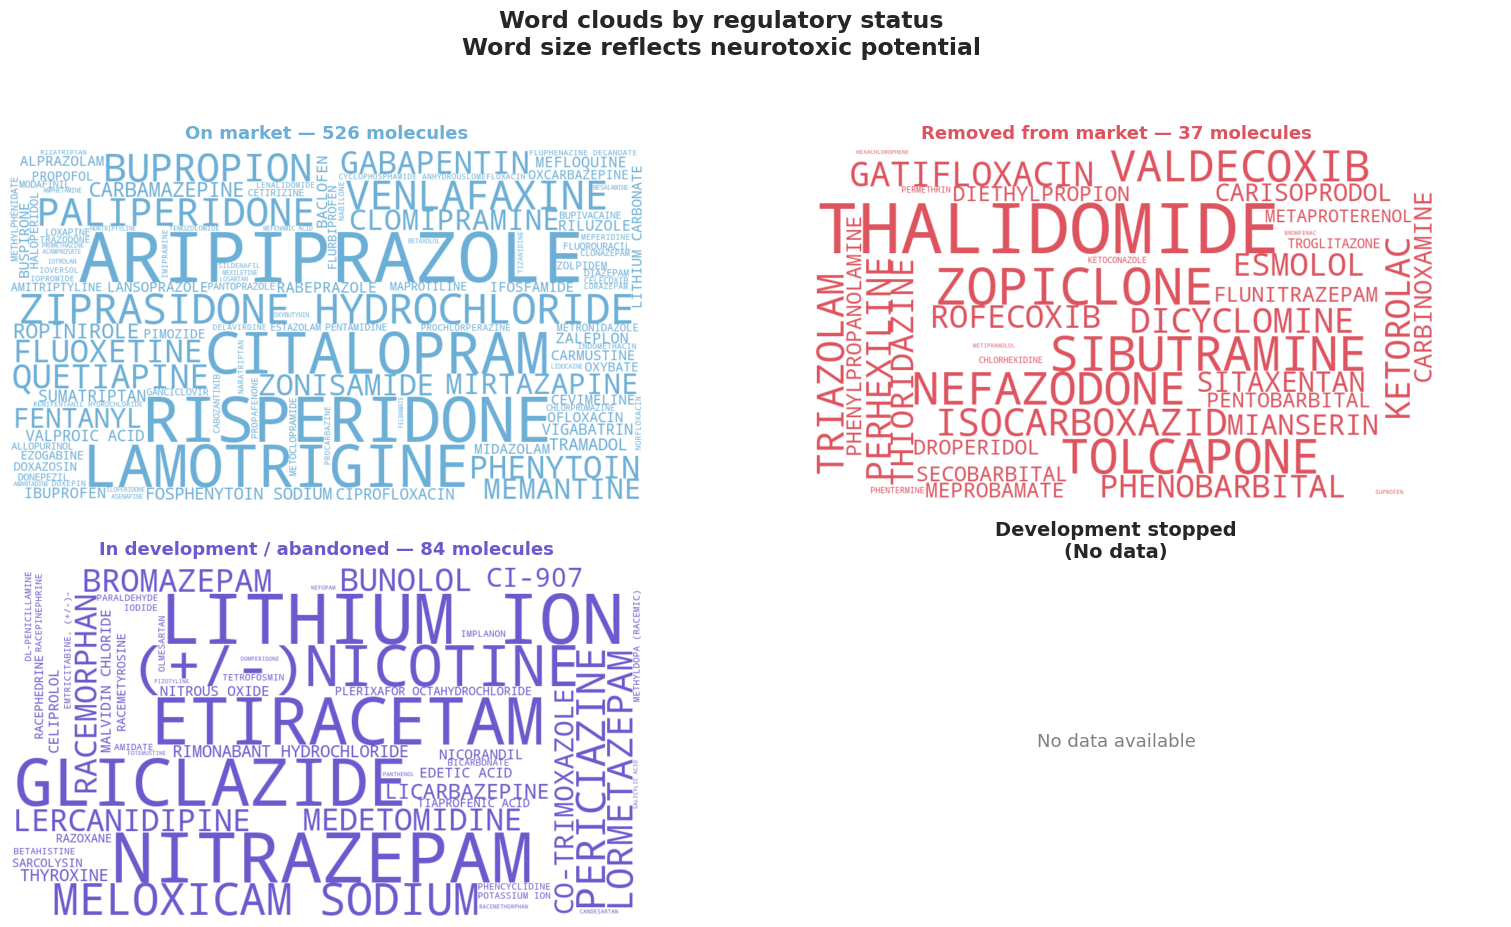

WordCloud grid saved → images/wordclouds_regulatory_statuses_neurotoxicity.png


In [ ]:
# ############################################################# #
# WordCloud — Regulatory status × Neurotoxicity
# ############################################################# #

# --- Load data ---
mapping_df = pd.read_csv(processed_dir / "inchikey_to_chembl.csv")
labels_df  = pd.read_csv(processed_dir / "labels_with_pubchemCID.csv")
status_df  = pd.read_csv(processed_dir / "chembl_status.csv")

# --- Cleaning and merging ---
mapping_df = mapping_df.drop_duplicates(subset=["chembl_id", "stitch_id_flat"])
status_df  = status_df.drop_duplicates(subset=["chembl_id"])
labels_df  = labels_df.drop_duplicates(subset=["stitch_id_flat"])

merged_df = (
    mapping_df
    .merge(status_df, on="chembl_id", how="left")
    .merge(labels_df, on="stitch_id_flat", how="left")
)

# --- Normalize and clean key columns ---
merged_df["withdrawn_flag"] = merged_df["withdrawn_flag"].astype(str).replace({"True": True, "False": False})
merged_df["max_phase"] = pd.to_numeric(merged_df["max_phase"], errors="coerce").fillna(0).astype(int)

# ============================================================ #
# Combined regulatory status
# ============================================================ #
merged_df["status_combo"] = merged_df.apply(
    lambda r: (
        "Approved & withdrawn (removed from market)" if r["max_phase"] == 4 and r["withdrawn_flag"] else
        "Approved & not withdrawn (on market)" if r["max_phase"] == 4 else
        "Not approved & withdrawn (development stopped)" if r["withdrawn_flag"] else
        "Not approved & not withdrawn (in development / abandoned)"
    ),
    axis=1
)

# --- Detect molecule name column ---
for col in ["pref_name", "molecule_name", "chembl_name"]:
    if col in merged_df.columns:
        name_col = col
        break
else:
    raise ValueError("No molecule name column found in merged dataset.")

# ============================================================ #
# Status display mapping and consistent color palette
# ============================================================ #
status_display = {
    "Approved & not withdrawn (on market)": "On market",
    "Approved & withdrawn (removed from market)": "Removed from market",
    "Not approved & not withdrawn (in development / abandoned)": "In development / abandoned",
    "Not approved & withdrawn (development stopped)": "Development stopped"
}

status_colors = {
    "Approved & not withdrawn (on market)": blue_approved,    
    "Approved & withdrawn (removed from market)": red_not_approved,
    "Not approved & not withdrawn (in development / abandoned)": violet_main,
    "Not approved & withdrawn (development stopped)": rose_light_non_tox
}

# ============================================================ #
# Generate 2×2 WordCloud grid
# ============================================================ #
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
axes = axes.flatten()

for ax, (status_label, display_label) in zip(axes, status_display.items()):
    color = status_colors[status_label]
    subset = merged_df[merged_df["status_combo"] == status_label]
    n_total = subset[name_col].nunique()

    if subset.empty or name_col not in subset:
        ax.text(0.5, 0.5, "No data available", ha="center", va="center",
                fontsize=13, color="gray")
        ax.set_title(f"{display_label}\n(No data)", fontsize=14, weight="bold")
        ax.axis("off")
        continue

    # --- Frequency proportional to neurotoxicity potential ---
    if "n_neuro_pt" in subset.columns and subset["n_neuro_pt"].notna().any():
        freq = (
            subset.groupby(name_col)["n_neuro_pt"]
            .sum()
            .replace(0, 0.5)  # avoid zero-sized words
            .to_dict()
        )
    else:
        freq = subset[name_col].value_counts().to_dict()

    wc = WordCloud(
        width=900, height=500,
        background_color="white",
        color_func=lambda *args, **kwargs: color,
        prefer_horizontal=0.9,
        min_font_size=8,
        max_font_size=100,
        relative_scaling=0.7,
        normalize_plurals=True
    ).generate_from_frequencies(freq)

    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(
        f"{display_label} — {n_total} molecules",
        fontsize=13, weight="bold", color=color, pad=8
    )

# ============================================================ #
# Global title and save
# ============================================================ #
plt.suptitle(
    "Word clouds by regulatory status\n"
    "Word size reflects neurotoxic potential",
    fontsize=17, weight="bold", y=1.03
)
plt.tight_layout()

save_path = images_dir / "wordclouds_regulatory_statuses_neurotoxicity.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()

print(f"WordCloud grid saved → {save_path}")


Each cloud represents molecules grouped by **regulatory status** (approved, withdrawn, in development),  
and the **word size reflects their neurotoxic potential**.

- The **largest words** among **marketed drugs** (e.g., *aripiprazole*, *risperidone*, *lamotrigine*, *bupropion*) are **CNS-active compounds**,  confirming that many **approved neuroactive agents** carry **detectable neurotoxic risk**, often as dose-dependent adverse effects.

- The **withdrawn drugs** (*thalidomide*, *sibutramine*, *valdecoxib*, *nefazodone*, *tolcapone*) show **clear neurotoxic or CNS-related profiles**,  highlighting **neurotoxicity as a frequent cause of market withdrawal**.

- The **development / abandoned** cluster (e.g., *lithium*, *nitrazepam*, *levetiracetam*) contains both experimental and CNS-acting agents,  suggesting that **CNS-active pharmacology remains high-risk** in later-stage development.

These word clouds visually confirm that **neurotoxicity is overrepresented among CNS-targeting drugs**, and remains a **major limiting factor** in clinical approval and post-marketing safety.


## V) Therapeutic indication analysis 

In this section, the goal is to explore **how neurotoxicity is distributed across therapeutic indications**.  
By linking each molecule to its **ChEMBL therapeutic use annotations**, we can identify which medical conditions are most frequently associated with neurotoxic drugs.


---

**Source:** [ChEMBL drug indication endpoint](https://www.ebi.ac.uk/chembl/api/data/drug_indication)



In [ ]:
# ############################################################# #
# V) Therapeutic indication analysis (ChEMBL)
# ############################################################# #

map_path   = processed_dir / "inchikey_to_chembl.csv"
out_indic  = processed_dir / "chembl_indications.csv"

mapping_df = pd.read_csv(map_path)
chembl_ids = mapping_df["chembl_id"].dropna().unique().tolist()

display(Markdown(f"""
### **Therapeutic indication download**
Number of molecules to query: **{len(chembl_ids):,}**
"""))

# ============================================================ #
# HTTP session setup
# ============================================================ #
session = requests.Session()
session.headers.update({
    "User-Agent": "Neurotox_project (Master Digipharm student project)",
    "Accept": "application/json"
})

# ============================================================ #
# Function to fetch indications for a ChEMBL ID
# ============================================================ #
def fetch_indications(chembl_id: str) -> list[dict]:
    """
    Retrieve therapeutic indications for a given molecule_chembl_id from ChEMBL.
    Returns a list of dictionaries containing MeSH / EFO terms and phase info.
    """
    url = "https://www.ebi.ac.uk/chembl/api/data/drug_indication.json"
    params = {"molecule_chembl_id": chembl_id, "limit": 100}
    try:
        r = session.get(url, params=params, timeout=20)
        if r.status_code != 200:
            return []
        data = r.json().get("drug_indications", [])
        return [
            {
                "chembl_id": chembl_id,
                "mesh_heading": d.get("mesh_heading"),
                "efo_term": d.get("efo_term"),
                "max_phase_for_indication": d.get("max_phase_for_indication")
            }
            for d in data
        ]
    except Exception:
        return []

# ============================================================ #
# Download loop 
# ============================================================ #
indications_all = []
print(f"\nFetching indications for {len(chembl_ids):,} molecules from ChEMBL...\n")

for chembl_id in tqdm(chembl_ids, desc="Downloading indications", unit="molecule"):
    rows = fetch_indications(chembl_id)
    if rows:
        indications_all.extend(rows)
    time.sleep(0.05)  

# ============================================================ #
# Save and summarize
# ============================================================ #
df_indic = pd.DataFrame(indications_all)
df_indic.to_csv(out_indic, index=False)

n_rows = len(df_indic)
n_indications = df_indic["mesh_heading"].nunique() if not df_indic.empty else 0

display(Markdown(f"""
---
### **Download complete**
| Item | Value |
|------|--------|
| **Queried molecules** | {len(chembl_ids):,} |
| **Indication entries retrieved** | {n_rows:,} |
| **Unique indications (MeSH terms)** | {n_indications:,} |
| **Saved file** | `{out_indic.name}` |
---
"""))

if not df_indic.empty:
    display(df_indic.head(10))
else:
    print("No indications retrieved. Check API connection or molecule mapping.")



### **Therapeutic indication download**
Number of molecules to query: **938**



Fetching indications for 938 molecules from ChEMBL...




---
### **Download complete**
| Item | Value |
|------|--------|
| **Queried molecules** | 938 |
| **Indication entries retrieved** | 8,836 |
| **Unique indications (MeSH terms)** | 1,295 |
| **Saved file** | `chembl_indications.csv` |
---


chembl_id                                mesh_heading  \
0     CHEMBL1521  Sleep Initiation and Maintenance Disorders   
1     CHEMBL1521                                     Anxiety   
2     CHEMBL1521                                    Dementia   
3     CHEMBL1521                         Depressive Disorder   
4     CHEMBL1521                               Schizophrenia   
5     CHEMBL1521                        Sleep Wake Disorders   
6  CHEMBL1082407                         Prostatic Neoplasms   
7  CHEMBL1082407                         Prostatic Neoplasms   
8  CHEMBL1082407                         Prostatic Neoplasms   
9  CHEMBL1082407                                   Neoplasms   

                     efo_term max_phase_for_indication  
0                    insomnia                     None  
1                     anxiety                     None  
2                    Dementia                     None  
3         depressive disorder                     None  
4               schizophrenia                     None  
5              Sleep Disorder                     None  
6     prostate adenocarcinoma                     None  
7          prostate carcinoma                     None  
8  metastatic prostate cancer                     None  
9                    neoplasm                     None


### **Indication summary**
- **Unique indications (MeSH):** 1,295
- **Average indications per molecule:** 14.41
- **Molecules with neurotoxicity annotation:** 938


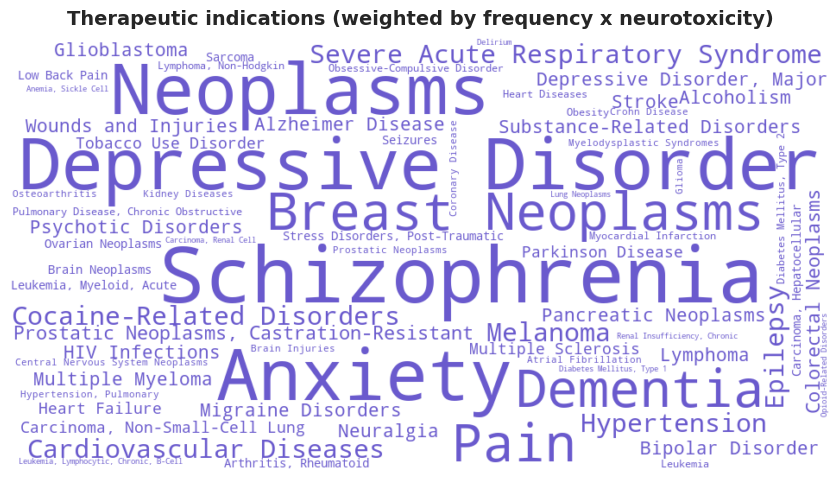

WordCloud saved → images/indications_wordcloud_neurotoxicity.png


In [ ]:
# ############################################################# #
# Therapeutic indications: statistics and visualization
# ############################################################# #

sns.set_theme(style="whitegrid", font_scale=1.1)

# ============================================================ #
# Load datasets
# ============================================================ #
indic_path = processed_dir / "chembl_indications.csv"

mapping_df = pd.read_csv(processed_dir / "inchikey_to_chembl.csv")
labels_df  = pd.read_csv(processed_dir / "meta_labels.csv")
indic_df   = pd.read_csv(indic_path)

# ============================================================ #
# Clean and prepare indications
# ============================================================ #
indic_df = (
    indic_df
    .dropna(subset=["mesh_heading"])
    .drop_duplicates(subset=["chembl_id", "mesh_heading"])
)

# ============================================================ #
# Merge with mapping and neurotoxicity labels
# ============================================================ #
merged_df = (
    mapping_df
    .merge(labels_df, on="stitch_id_flat", how="left")
    .merge(indic_df, on="chembl_id", how="left")
)

# Keep only compounds with known neurotoxicity label
merged_df = merged_df.dropna(subset=["neurotoxic"]).copy()
merged_df["neurotoxic"] = merged_df["neurotoxic"].astype(int)

# ============================================================ #
# Global statistics summary
# ============================================================ #
n_indic = indic_df["mesh_heading"].nunique()
mean_per_molecule = indic_df.groupby("chembl_id").size().mean()

display(Markdown(f"""
### **Indication summary**
- **Unique indications (MeSH):** {n_indic:,}
- **Average indications per molecule:** {mean_per_molecule:.2f}
- **Molecules with neurotoxicity annotation:** {merged_df["chembl_id"].nunique():,}
"""))

# ============================================================ #
# Neurotoxicity rate per indication
# ============================================================ #
indic_counts = (
    merged_df.groupby(["mesh_heading", "neurotoxic"])
    .size()
    .reset_index(name="count")
)

indic_total = indic_counts.groupby("mesh_heading")["count"].sum().reset_index(name="total")

indic_neuro = (
    indic_counts[indic_counts["neurotoxic"] == 1]
    .groupby("mesh_heading")["count"]
    .sum()
    .reset_index(name="neuro_count")
)

indic_stats = indic_total.merge(indic_neuro, on="mesh_heading", how="left").fillna(0)
indic_stats["neurotoxicity_rate"] = indic_stats["neuro_count"] / indic_stats["total"]


# ============================================================ #
# WordCloud weighted by frequency × neurotoxicity rate
# ============================================================ #
indic_stats["weighted_score"] = indic_stats["neurotoxicity_rate"] * np.log1p(indic_stats["total"])

word_freq_weighted = {
    row["mesh_heading"]: row["weighted_score"]
    for _, row in indic_stats.iterrows()
    if isinstance(row["mesh_heading"], str)
}

wc = WordCloud(
    width=950, height=500,
    background_color="white",
    color_func=lambda *args, **kwargs: violet_main, 
    relative_scaling=0.6,
    normalize_plurals=True,
    prefer_horizontal=0.9,
    min_font_size=8,
    max_font_size=90
).generate_from_frequencies(word_freq_weighted)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Therapeutic indications (weighted by frequency x neurotoxicity)",
          fontsize=14, weight="bold", pad=10)
plt.tight_layout()

save_path = images_dir / "indications_wordcloud_neurotoxicity.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()

print(f"WordCloud saved → {save_path}")


### **Therapeutic indications — weighted by frequency × neurotoxicity**

- The word cloud combines **therapeutic prevalence** and **neurotoxicity rate**, emphasizing diseases with both **many drugs** and **high neurotoxic risk**.  
- The dominant terms **Schizophrenia, Dementia, Depressive Disorder, Anxiety, Pain, and Neoplasms** reveal that **psychiatric and neurological conditions** are the most represented and the most neurotoxic in this sample.  
- This reflects the pharmacological reality: **CNS-active drugs** (antipsychotics, antidepressants, antiepileptics) are among the **most effective yet neurotoxic** therapeutic classes.  
- Interestingly, some **oncological indications** (*breast neoplasms, melanoma, leukemia*) also appear prominently, suggesting **neurotoxic effects linked to chemotherapy** or systemic cytotoxicity.



## Physicochemical characterization

In this section, we analyze the  **physicochemical composition** using both **ChEMBL data** and **RDKit** calculations, including:

| Property | Meaning | Relevance to neurotoxicity |
|-----------|----------|-----------------------------|
| **Molecular weight (MW)** | Size of the molecule | Affects absorption and brain permeability |
| **LogP** | Lipophilicity | High LogP favors blood–brain barrier penetration |
| **HBA / HBD** | H-bond acceptors / donors | Influence polarity and solubility |
| **TPSA** | Topological polar surface area | Low TPSA → better CNS access |
| **Rotatable bonds** | Molecular flexibility | Impacts metabolic stability |
| **Aromatic rings** | Structural rigidity | Often linked to CNS activity |


### Source

[`https://www.ebi.ac.uk/chembl/api/data/molecule/`](https://www.ebi.ac.uk/chembl/api/data/molecule/)

In [ ]:
# ############################################################# #
# VI) Physicochemical Property Enrichment — ChEMBL
# ############################################################# #


# ============================================================ #
# Paths and data loading
# ============================================================ #
map_path    = processed_dir / "inchikey_to_chembl.csv"
struct_path = processed_dir / "labels_with_smiles_inchikey.csv"
out_props   = processed_dir / "chembl_properties.csv"

mapping_df = pd.read_csv(map_path)
mapping_df = mapping_df.dropna(subset=["chembl_id", "stitch_id_flat"]).drop_duplicates("chembl_id")

chembl_ids = mapping_df["chembl_id"].unique().tolist()
n_total = len(chembl_ids)

print(f"Starting physicochemical property download from ChEMBL for {n_total:,} molecules...")

# ============================================================ #
# ChEMBL API session
# ============================================================ #
session = requests.Session()
session.headers.update({"User-Agent": "Neurotox project (Master Digipharm student project)"})

# ============================================================ #
# Function to retrieve molecular properties from ChEMBL
# ============================================================ #
def fetch_properties(chembl_id):
    """Fetch molecular physicochemical properties from ChEMBL API."""
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.json"
    try:
        r = session.get(url, timeout=10)
        if r.status_code != 200:
            return None
        d = r.json().get("molecule_properties", {})
        if not d:
            return None
        return {
            "chembl_id": chembl_id,
            "cx_logp": d.get("cx_logp"),
            "full_molformula": d.get("full_molformula"),
            "full_mwt": d.get("full_mwt"),
            "aromatic_rings": d.get("aromatic_rings"),
            "hba": d.get("hba"),
            "hbd": d.get("hbd"),
            "psa": d.get("psa"),
            "rtb": d.get("rtb")
        }
    except Exception:
        return None

# ============================================================ #
# Download loop with progress bar
# ============================================================ #
records = []
with tqdm(total=n_total, desc="Downloading ChEMBL properties", unit="molecule", ncols=90) as pbar:
    for chembl_id in chembl_ids:
        props = fetch_properties(chembl_id)
        if props:
            records.append(props)
        pbar.update(1)
        time.sleep(0.05)

props_df = pd.DataFrame(records)
print(f"\nRetrieved {len(props_df)} molecules with physicochemical data from {n_total}")

# ============================================================ #
# Merge with SMILES for RDKit backup computation
# ============================================================ #
props_df = props_df.merge(mapping_df[["chembl_id", "stitch_id_flat"]], on="chembl_id", how="left")
struct_df = pd.read_csv(struct_path)[["stitch_id_flat", "smiles"]]
props_df = props_df.merge(struct_df, on="stitch_id_flat", how="left")

# ============================================================ #
# RDKit fallback for missing values (logP, MW, HBA/HBD, PSA)
# ============================================================ #
def compute_rdkit_props(smiles):
    """Compute molecular descriptors using RDKit for missing ChEMBL data."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [np.nan] * 5
        logP = Crippen.MolLogP(mol)
        mol_wt = Descriptors.MolWt(mol)
        hba = Descriptors.NumHAcceptors(mol)
        hbd = Descriptors.NumHDonors(mol)
        tpsa = Descriptors.TPSA(mol)
        return [logP, mol_wt, hba, hbd, tpsa]
    except Exception:
        return [np.nan] * 5

mask = props_df["cx_logp"].isna() | props_df["full_mwt"].isna()
print(f"Computing RDKit backup properties for {mask.sum()} missing molecules...")

props_calc = props_df.loc[mask, "smiles"].apply(compute_rdkit_props)
props_calc = pd.DataFrame(
    props_calc.tolist(),
    columns=["rdkit_logP", "rdkit_MolWt", "rdkit_HAcceptors", "rdkit_HDonors", "rdkit_TPSA"]
)

props_df.loc[mask, ["rdkit_logP", "rdkit_MolWt", "rdkit_HAcceptors", "rdkit_HDonors", "rdkit_TPSA"]] = props_calc.values

# ============================================================ #
# Merge and prioritize ChEMBL values over RDKit
# ============================================================ #
props_df["cx_logp"] = props_df["cx_logp"].fillna(props_df["rdkit_logP"])
props_df["full_mwt"] = props_df["full_mwt"].fillna(props_df["rdkit_MolWt"])
props_df["hba"] = props_df["hba"].fillna(props_df["rdkit_HAcceptors"])
props_df["hbd"] = props_df["hbd"].fillna(props_df["rdkit_HDonors"])
props_df["psa"] = props_df["psa"].fillna(props_df["rdkit_TPSA"])

# ============================================================ #
# Cleanup and reorder columns
# ============================================================ #
props_df = props_df[[c for c in props_df.columns if not c.startswith("rdkit_")]]

cols_order = [
    "chembl_id", "stitch_id_flat", "smiles",
    "cx_logp", "full_molformula", "full_mwt",
    "aromatic_rings", "hba", "hbd", "psa", "rtb"
]
props_df = props_df[[c for c in cols_order if c in props_df.columns]]

# ============================================================ #
# Save the cleaned and enriched dataset
# ============================================================ #
props_df.to_csv(out_props, index=False)
print(f"Cleaned and enriched file saved → {out_props}")
print(f"LogP completeness: {props_df['cx_logp'].notna().mean()*100:.1f}%")
print(f"Molecular weight completeness: {props_df['full_mwt'].notna().mean()*100:.1f}%")

# ============================================================ #
# Markdown summary
# ============================================================ #
display(Markdown(f"""
---
### **Physicochemical enrichment completed**
File saved → `{out_props.name}`
---

| Field | Source | Description |
|:------|:--------|:-------------|
| `cx_logp` | ChEMBL / RDKit | Lipophilicity (logP) |
| `full_mwt` | ChEMBL / RDKit | Molecular weight (g/mol) |
| `hba` / `hbd` | ChEMBL / RDKit | Hydrogen bond acceptors/donors |
| `psa` | ChEMBL / RDKit | Polar surface area |
| `rtb` | ChEMBL | Rotatable bonds |
| `aromatic_rings` | ChEMBL | Aromatic ring count |
| `full_molformula` | ChEMBL | Molecular formula |.
"""))


Starting physicochemical property download from ChEMBL for 938 molecules...



Retrieved 938 molecules with physicochemical data from 938
Computing RDKit backup properties for 938 missing molecules...
Cleaned and enriched file saved → data/processed/chembl_properties.csv
LogP completeness: 100.0%
Molecular weight completeness: 100.0%



---
### **Physicochemical enrichment completed**
File saved → `chembl_properties.csv`
---

| Field | Source | Description |
|:------|:--------|:-------------|
| `cx_logp` | ChEMBL / RDKit | Lipophilicity (logP) |
| `full_mwt` | ChEMBL / RDKit | Molecular weight (g/mol) |
| `hba` / `hbd` | ChEMBL / RDKit | Hydrogen bond acceptors/donors |
| `psa` | ChEMBL / RDKit | Polar surface area |
| `rtb` | ChEMBL | Rotatable bonds |
| `aromatic_rings` | ChEMBL | Aromatic ring count |
| `full_molformula` | ChEMBL | Molecular formula |.


Loading file: data/processed/chembl_properties.csv
Data loaded successfully (938 rows, 11 columns)



## General overview of the ChEMBL dataset (physicochemical properties)

chembl_id stitch_id_flat  \
0  CHEMBL1233550   CID100024841   
1   CHEMBL178240   CID100005726   
2  CHEMBL5305350   CID104659568   
3  CHEMBL2138280   CID100071436   
4     CHEMBL1521   CID100005719   

                                              smiles  cx_logp full_molformula  \
0                                                  I  0.61800              HI   
1         CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)N=[N+]=[N-] -0.19628      C10H13N5O4   
2  CCN(CC)C(=O)C(=CC1=CC(=C(C(=C1)O)O)[N+](=O)[O-...  1.78138      C14H15N3O5   
3  CCCCCC(C=CC1C(CC(C1CC=CCCCC(=O)O)O)O)O.C(C(CO)...  0.70370       C24H45NO8   
4     CCN(C1=CC=CC(=C1)C2=CC=NC3=C(C=NN23)C#N)C(=O)C  2.64078       C17H15N5O   

   full_mwt  aromatic_rings  hba  hbd     psa   rtb  
0    127.91             0.0  0.0  0.0    0.00   0.0  
1    267.24             1.0  6.0  2.0  133.08   3.0  
2    305.29             1.0  6.0  2.0  127.70   5.0  
3    475.62             0.0  4.0  4.0   97.99  12.0  
4    305.34             3.0  5.0  0.0   74.29   3.0


- **Total number of rows:** 938  
- **Number of columns:** 11  
- **Available columns:** chembl_id, stitch_id_flat, smiles, cx_logp, full_molformula, full_mwt, aromatic_rings, hba, hbd, psa, rtb  


DataFrame structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   chembl_id        938 non-null    object 
 1   stitch_id_flat   938 non-null    object 
 2   smiles           938 non-null    object 
 3   cx_logp          938 non-null    float64
 4   full_molformula  938 non-null    object 
 5   full_mwt         938 non-null    float64
 6   aromatic_rings   904 non-null    float64
 7   hba              938 non-null    float64
 8   hbd              938 non-null    float64
 9   psa              938 non-null    float64
 10  rtb              904 non-null    float64
dtypes: float64(7), object(4)
memory usage: 80.7+ KB


### Descriptive statistics of numerical properties

### Missing values by variable

### Duplicates: 0 duplicate rows based on `chembl_id`

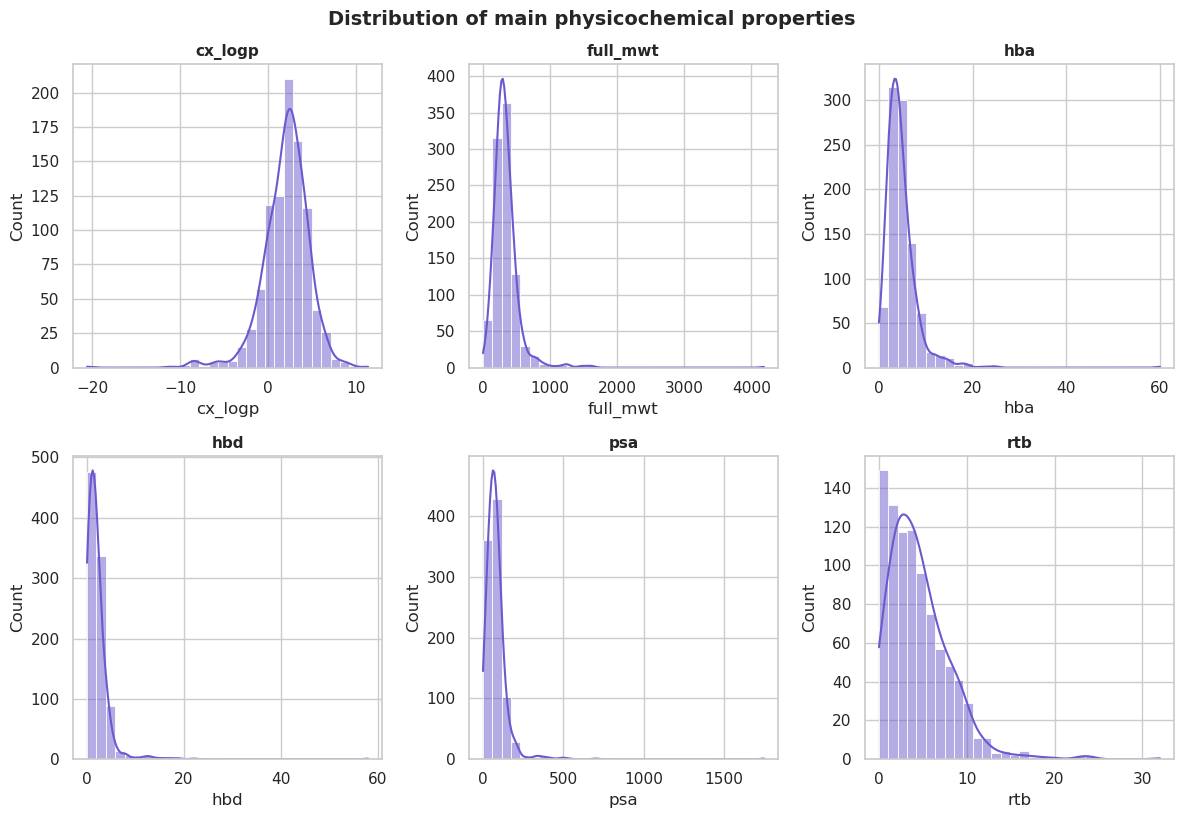

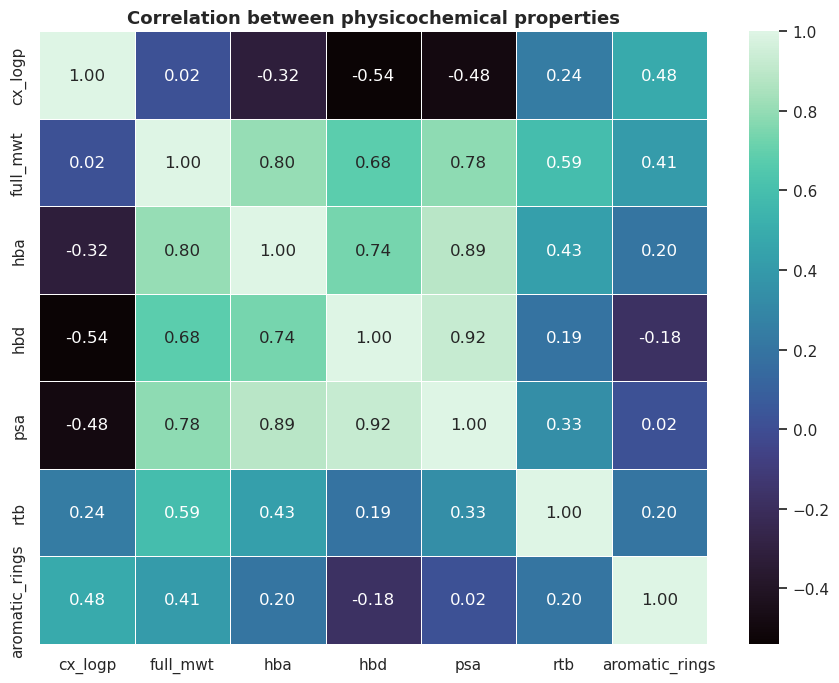

Heatmap saved successfully → images/heatmap_physchem_correlations.png


### Quality control summary

In [ ]:
# ############################################################# 
# Descriptive statistics and quality control 
# ############################################################# 

# ============================================================ #
# Load processed file
# ============================================================ #
file_path = processed_dir / "chembl_properties.csv"

print(f"Loading file: {file_path}")
df = pd.read_csv(file_path)
print(f"Data loaded successfully ({len(df):,} rows, {df.shape[1]} columns)\n")

# ============================================================ #
# General overview
# ============================================================ #
display(Markdown("## General overview of the ChEMBL dataset (physicochemical properties)"))  
display(df.head(5))

display(Markdown(f"""
- **Total number of rows:** {len(df):,}  
- **Number of columns:** {df.shape[1]}  
- **Available columns:** {', '.join(df.columns)}  
"""))

print("DataFrame structure:")
df.info()

# ============================================================ #
# Descriptive statistics
# ============================================================ #
display(Markdown("### Descriptive statistics of numerical properties"))
display(df.describe().T.style.background_gradient(cmap="mako"))

# ============================================================ #
# Missing values
# ============================================================ #
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({"Missing values": missing, "% of total": missing_pct})

display(Markdown("### Missing values by variable"))
display(missing_df.style.background_gradient(cmap="rocket_r"))

# ============================================================ #
# Duplicates
# ============================================================ #
n_duplicates = df.duplicated(subset=["chembl_id"]).sum()
display(Markdown(f"### Duplicates: {n_duplicates} duplicate rows based on `chembl_id`"))

# ============================================================ #
# Visualization: basic distributions
# ============================================================ #
sns.set_theme(style="whitegrid", palette="crest")

numeric_cols = ["cx_logp", "full_mwt", "hba", "hbd", "psa", "rtb", "aromatic_rings"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color=violet_main)
    plt.title(col, fontsize=11, weight="bold")
plt.tight_layout()
plt.suptitle("Distribution of main physicochemical properties", fontsize=14, weight="bold", y=1.02)
plt.show()

# ============================================================ #
# Correlations between properties
# ============================================================ #
images_dir.mkdir(exist_ok=True)
save_path = images_dir / "heatmap_physchem_correlations.png"

plt.figure(figsize=(9, 7))
ax = sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    cmap="mako",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation between physicochemical properties", fontsize=13, weight="bold")
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)
plt.show()

print(f"Heatmap saved successfully → {save_path}")

# ============================================================ #
# Quality control summary
# ============================================================ #
completeness = (100 - missing_pct).round(1)
qc_summary = pd.DataFrame({
    "Completeness rate (%)": completeness,
    "Missing values": missing,
})
display(Markdown("### Quality control summary"))
display(qc_summary.style.background_gradient(cmap="crest", axis=0))


### **Physicochemical descriptors overview**

#### Correlations
- Strong positive correlations between **HBA, HBD, PSA, and molecular weight** indicate **redundancy** among polarity-related features.  
- **logP** is inversely correlated with these descriptors, capturing **hydrophobicity** independently.  
→ For ML, **feature normalization and dimensionality reduction (e.g., PCA)** will help mitigate redundancy and improve model efficiency.


Data loaded (1430 labels, 1430 structures)
File saved → data/processed/physicochemical_properties.csv (1,430 molecules)


### Mean physicochemical properties by class

Non-neurotoxic  Neurotoxic
logP                 1.125       1.302
MolWt              502.778     489.300
TPSA               144.949     141.772
HDonors              3.811       3.877
HAcceptors           7.456       6.954
RotBonds             8.774       8.538
QED                  0.448       0.518

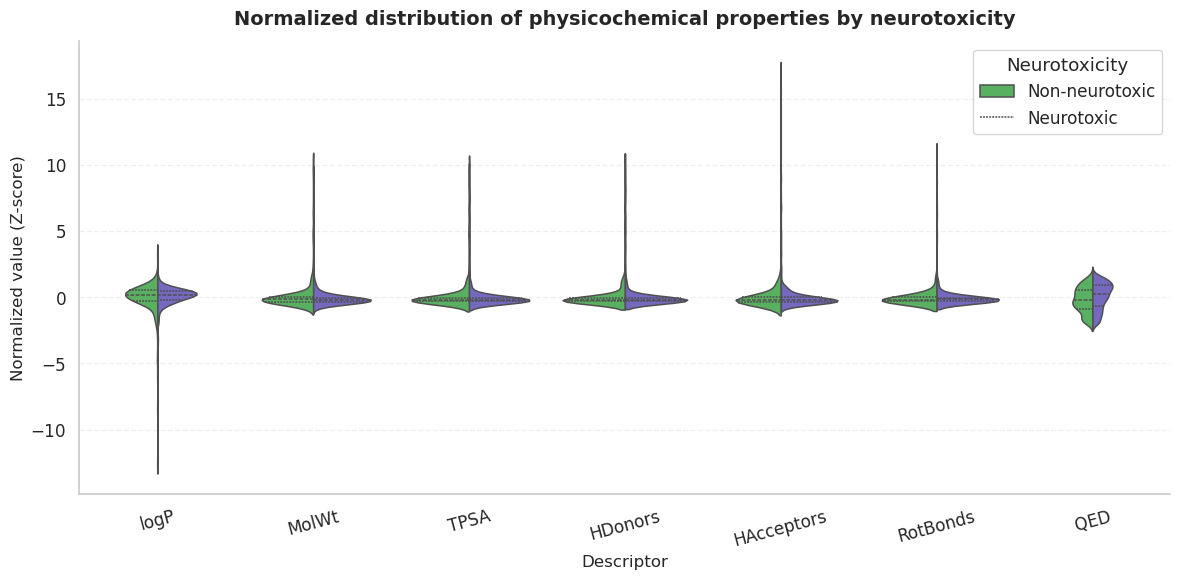

In [ ]:
# ============================================================ #
# Analysis of Physicochemical Properties (Multi-Descriptors)
# ============================================================ #

warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

# ------------------------------------------------------------ #
# Load data
# ------------------------------------------------------------ #
labels  = pd.read_csv(processed_dir / "meta_labels.csv")
struct  = pd.read_csv(processed_dir / "labels_with_smiles_inchikey.csv")
mapping = pd.read_csv(processed_dir / "inchikey_to_chembl.csv")
status  = pd.read_csv(processed_dir / "chembl_status.csv")
props_chembl = pd.read_csv(processed_dir / "chembl_properties.csv")

print(f"Data loaded ({len(labels)} labels, {len(struct)} structures)")

# ------------------------------------------------------------ #
# Merge datasets
# ------------------------------------------------------------ #
df = (
    labels
    .merge(struct, on="stitch_id_flat", how="left")
    .merge(mapping[["stitch_id_flat", "chembl_id"]], on="stitch_id_flat", how="left")
    .merge(status, on="chembl_id", how="left")
    .merge(props_chembl[["chembl_id", "cx_logp", "full_mwt", "psa", "hba", "hbd", "rtb"]], on="chembl_id", how="left")
)

# Clean duplicated columns (_x/_y)
for base in ["drug_name", "neurotoxic"]:
    if f"{base}_x" in df.columns and f"{base}_y" in df.columns:
        df[base] = df[f"{base}_x"].combine_first(df[f"{base}_y"])
df = df[[c for c in df.columns if not c.endswith(("_x", "_y"))]]

# Filter valid molecules with SMILES
df = df.dropna(subset=["smiles"]).reset_index(drop=True)
df["neurotoxic"] = pd.to_numeric(df["neurotoxic"], errors="coerce").fillna(0).astype(int)

# ------------------------------------------------------------ #
# Compute RDKit descriptors
# ------------------------------------------------------------ #
def compute_rdkit_props(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [np.nan]*7
        logP = Crippen.MolLogP(mol)
        mol_wt = Descriptors.MolWt(mol)
        tpsa = Descriptors.TPSA(mol)
        h_donors = Descriptors.NumHDonors(mol)
        h_acceptors = Descriptors.NumHAcceptors(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        qed_val = QED.qed(mol)
        return [logP, mol_wt, tpsa, h_donors, h_acceptors, rot_bonds, qed_val]
    except Exception:
        return [np.nan]*7

props = df["smiles"].apply(compute_rdkit_props)
props = pd.DataFrame(
    props.tolist(),
    columns=["logP", "MolWt", "TPSA", "HDonors", "HAcceptors", "RotBonds", "QED"]
)
df = pd.concat([df, props], axis=1)

# ------------------------------------------------------------ #
# Save enriched dataset
# ------------------------------------------------------------ #
out_path = processed_dir / "physicochemical_properties.csv"
df.to_csv(out_path, index=False)
print(f"File saved → {out_path} ({len(df):,} molecules)")

# ------------------------------------------------------------ #
# Descriptive statistics (mean values per class)
# ------------------------------------------------------------ #
desc_cols = ["logP", "MolWt", "TPSA", "HDonors", "HAcceptors", "RotBonds", "QED"]
stats_summary = df.groupby("neurotoxic")[desc_cols].mean().T.round(3)
stats_summary.columns = ["Non-neurotoxic", "Neurotoxic"]

display(Markdown("### Mean physicochemical properties by class"))
display(stats_summary)

# ------------------------------------------------------------ #
# Visualization : Normalized distributions (violin plot)
# ------------------------------------------------------------ #
plot_features = ["logP", "MolWt", "TPSA", "HDonors", "HAcceptors", "RotBonds", "QED"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[plot_features] = scaler.fit_transform(df_scaled[plot_features])

df_melt = df_scaled.melt(
    id_vars="neurotoxic",
    value_vars=plot_features,
    var_name="Descriptor",
    value_name="Normalized value"
)

palette = {0: green_light, 1: violet_main}

plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_melt,
    x="Descriptor", y="Normalized value", hue="neurotoxic",
    split=True, inner="quart", linewidth=1.1, palette=palette
)

plt.title("Normalized distribution of physicochemical properties by neurotoxicity",
          fontsize=14, weight="bold", pad=12)
plt.xlabel("Descriptor", fontsize=12)
plt.ylabel("Normalized value (Z-score)", fontsize=12)
plt.legend(title="Neurotoxicity", labels=["Non-neurotoxic", "Neurotoxic"], loc="upper right")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


### **Physicochemical properties by neurotoxicity class**

- Neurotoxic molecules show a **slightly higher logP (1.30 vs 1.12)** → they are **more lipophilic**, suggesting better **blood–brain barrier penetration**, consistent with their CNS effects.  
- **Molecular weight (≈500 Da)** and **TPSA** are similar across classes,  
  indicating that **size and polarity alone don’t distinguish neurotoxicity**.  
- **H-donors, H-acceptors**, **rotatable bonds** and **QED (drug-likeness)** remain comparable, showing **no major structural bias**.  


In [ ]:
# ============================================================ #
# Fusion of all data
# ============================================================ #

# ------------------------------------------------------------ #
# Paths
# ------------------------------------------------------------ #
final_path  = processed_dir / "data_final.csv"
phys_path   = processed_dir / "physicochemical_properties.csv"
status_path = processed_dir / "chembl_status.csv"
map_path    = processed_dir / "inchikey_to_chembl.csv"
labels_path = processed_dir / "labels_with_smiles_inchikey.csv"
out_path    = processed_dir / "data_final_physchem_status.csv"

# ------------------------------------------------------------ #
# Load datasets
# ------------------------------------------------------------ #
final_df = pd.read_csv(final_path)
physchem = pd.read_csv(phys_path)
status   = pd.read_csv(status_path)
mapping  = pd.read_csv(map_path)
labels   = pd.read_csv(labels_path)

# ------------------------------------------------------------ #
# Merge neurotoxic potential from labels
# ------------------------------------------------------------ #
if "n_neuro_pt" not in labels.columns:
    raise ValueError("Column 'n_neuro_pt' is missing in labels_with_smiles_inchikey.csv")

final_df = final_df.merge(labels[["stitch_id_flat", "n_neuro_pt"]], on="stitch_id_flat", how="left")

# ------------------------------------------------------------ #
# Select relevant physicochemical columns
# ------------------------------------------------------------ #
phys_cols = [
    "logP", "MolWt", "TPSA",
    "HDonors", "HAcceptors",
    "RotBonds", "QED"
]
available_phys_cols = [c for c in phys_cols if c in physchem.columns]

# ------------------------------------------------------------ #
# Prepare reduced DataFrames for merging
# ------------------------------------------------------------ #
physchem_small = physchem[["stitch_id_flat"] + available_phys_cols].drop_duplicates("stitch_id_flat")
status_small = status[["chembl_id", "first_approval", "withdrawn_flag"]]
mapping_small = mapping[["stitch_id_flat", "chembl_id"]]

# Merge mapping with status
status_merged = mapping_small.merge(status_small, on="chembl_id", how="left")

# ------------------------------------------------------------ #
# Final merge: dataset + physchem + status
# ------------------------------------------------------------ #
merged = (
    final_df
    .merge(physchem_small, on="stitch_id_flat", how="left")
    .merge(status_merged.drop(columns=["chembl_id"]), on="stitch_id_flat", how="left")
)

# ------------------------------------------------------------ #
# Reorganize column order
# ------------------------------------------------------------ #
cols = list(merged.columns)
if "n_neuro_pt" in cols and "drug_name" in cols and "neurotoxic" in cols:
    cols.insert(cols.index("neurotoxic"), cols.pop(cols.index("n_neuro_pt")))
    merged = merged[cols]

before_cols = list(merged.columns[: merged.columns.get_loc("neurotoxic") + 1])
physchem_order = [c for c in available_phys_cols if c in merged.columns]
status_cols = [c for c in ["first_approval", "withdrawn_flag"] if c in merged.columns]
remaining_cols = [c for c in merged.columns if c not in before_cols + physchem_order + status_cols]
new_order = before_cols + physchem_order + status_cols + remaining_cols
merged = merged[new_order]

# ------------------------------------------------------------ #
# Save the merged dataset
# ------------------------------------------------------------ #
merged.to_csv(out_path, index=False)

# ============================================================ #
# Summary and Quality Control
# ============================================================ #
n_rows, n_cols = merged.shape
missing = merged.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(merged) * 100).round(2)
missing_df = pd.DataFrame({"Missing values": missing, "% of total": missing_pct})
top_missing = missing_df.head(10)

display(Markdown(f"""
### Final merge and enrichment completed
- **File saved:** `{out_path.name}`  
- **Total rows:** {n_rows:,}  
- **Total columns:** {n_cols:,}  

| Category | Number of columns |
|:-----------|:------------------:|
| Physicochemical properties added | {len(physchem_order)} |
| Regulatory status variables | {len(status_cols)} |
| Total | {n_cols:,} |
"""))

# ------------------------------------------------------------ #
# Data types overview
# ------------------------------------------------------------ #
display(Markdown("### Data types by column"))

types_df = pd.DataFrame(merged.dtypes, columns=["Type"])
html_types = types_df.T.to_html(classes='T_f13d8', border=0)

style = """
<style type="text/css">
#T_f13d8 th {
  font-weight: bold;
  background-color: #f5f5f5;
  text-align: left;
}
#T_f13d8 td {
  padding: 4px 8px;
}
</style>
"""
display(HTML(style + html_types))

# ------------------------------------------------------------ #
# Missing values overview
# ------------------------------------------------------------ #
display(Markdown("### Top 10 variables with most missing values"))
display(top_missing.style.background_gradient(cmap="Reds"))

# ------------------------------------------------------------ #
# Dataset preview
# ------------------------------------------------------------ #
display(Markdown("### Preview of the merged dataset"))
display(
    merged.head(5).style.set_table_styles(
        [{'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#f5f5f5')]}]
    )
)



### Final merge and enrichment completed
- **File saved:** `data_final_physchem_status.csv`  
- **Total rows:** 1,430  
- **Total columns:** 2,263  

| Category | Number of columns |
|:-----------|:------------------:|
| Physicochemical properties added | 7 |
| Regulatory status variables | 2 |
| Total | 2,263 |


### Data types by column

### Top 10 variables with most missing values

### Preview of the merged dataset

# Machine Learning (perspectives)




### General objective

The goal of this section is to build and compare several **supervised Machine Learning models** to predict whether a molecule is **neurotoxic (1)** or **non-neurotoxic (0)** based on its **chemical**, **biological**, and **physicochemical** descriptors.

---

### Input data

We will use the final integrated dataset:  
`data_final_physchem_status.csv`

This dataset contains **1,430 molecules** and over **2,200 explanatory variables**, grouped into three main descriptor families:

| Descriptor type | Content | Source | Role |
|------------------|----------|---------|------|
| **Physicochemical** | logP, MW, TPSA, HBD, HBA, QED, pKa... | ChEMBL / RDKit | Structural and pharmacokinetic properties |
| **Biological** | 202 ChEMBL targets (one-hot) | ChEMBL | Known protein/receptor interactions |
| **Chemical** | 2048-bit ECFP4 fingerprints | RDKit | Molecular substructures |

The target variable is `neurotoxic` (binary: 0/1).

---

### ML pipeline overview

1. **Initial data exploration**
   - Check class distribution of `neurotoxic`  
   - Detect possible class imbalance  
   - Explore feature correlations and redundancy  

2. **Data preparation**
   - Separate features (`X`) and target (`y`)  
     ```python
     y = df["neurotoxic"]
     X = df.drop(columns=["neurotoxic", "stitch_id_flat", "drug_name"])
     ```
   - Split into **training** and **testing** sets (80/20)  
     `train_test_split(random_state=42, stratify=y)`
   - Standardize numeric variables (required for SVM)

3. **Model training and comparison**
   - **Random Forest (RF)** robust, interpretable  
   - **Support Vector Machine (SVM, RBF kernel)** effective for high-dimensional data  
   - **XGBoost (Gradient Boosting)** strong predictive power for tabular data  

4. **Model evaluation**
   - Metrics: **accuracy**, **precision**, **recall**, **F1-score**, **ROC–AUC**  
   - Visual tools: **confusion matrix**, **ROC curve**  
   - Identify **most important features** for interpretation  

---

### Expected interpretation (ML perspective)

- **Random Forest**: Excellent baseline, robust to noise, interpretable through feature importance.  
- **SVM (RBF)**: Handles complex, non-linear boundaries; well-suited for molecular fingerprints.  
- **XGBoost**: Excels at modeling non-linear interactions between chemical and biological features.  

→ The best model will be selected based on **balanced performance (AUC, F1)** and **interpretability**.

---

### References (ML in Toxicology)

- **Koutsoukas et al., 2017** — *Machine Learning for Toxicity Prediction Using Chemical Structures*  
- **Roy et al., 2021** — *QSAR Modelling of Chemical Toxicity: State of the Art and Future Perspectives*  
- **Gao et al., 2025** — *Integrating Molecular Fingerprints with Machine Learning for Accurate Neurotoxicity Prediction*  
- **Zhang et al., 2025** — *AI-Driven Drug Toxicity Prediction: Advances, Challenges, and Future Directions*  

